In [1]:
!python -m pip install -U gensim
!python -m pip install -U xgboost
!python -m pip install -U mlxtend

     |████████████████████████████████| 24.2MB 1.5MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 157.5MB 88kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 1.4MB 5.3MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


 # Notebook para detecção de quebra de diálogo

In [2]:
#imports
from os.path import join as pathjoin;
from os import listdir;
import os;
import re;
import json;
import matplotlib.pyplot as plt;
import pandas as pd;
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import numpy
import sklearn.pipeline
from gensim.models import KeyedVectors
from sklearn.model_selection import GridSearchCV
import math,glob

from mlxtend.regressor import StackingRegressor
from sklearn import linear_model
from sklearn.ensemble.forest import RandomForestRegressor as RFR
from sklearn.ensemble.forest import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn import neural_network
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Bases de desenvolvimento e teste

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
base_path = '/content/gdrive/My Drive/Mestrado/Conjuntos/DBDC4'
#base_path = 'C:/Users/Leonardo de Andrade/Dropbox/python/dbdc3/'
dev_data_path = pathjoin(base_path,'DBDC4_dev_20190312')
eval_data_path = pathjoin(base_path,'DBDC4_eval_20200314')

#output_data_path = pathjoin(base_path, 'experimento_v2_out/')
#wikpediaW2Vec = pathjoin(base_path,'wikpedia_embeddings/model.txt')
#word2vecGoogleNewsVectors = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'

In [5]:
def separateEval(originPath, destinationPath, count):
    files = listdir(originPath)
    eval_files = numpy.random.choice(files,count,False)
    if not os.path.exists(destinationPath):
        os.makedirs(destinationPath)
    for file in eval_files:
        os.rename(pathjoin(originPath,file),pathjoin(destinationPath,file))

### Separando 30% em arquivos de teste

In [6]:
# Comentando para não correr o risco de rodar novamente
#separateEval(cic_dev_path,cic_eval_path,34)
#separateEval(iris_dev_path,iris_eval_path,30)
#separateEval(tktk_dev_path,tktk_eval_path,30)
#separateEval(yi_dev_path,yi_eval_path,30)

### Funções úteis

In [7]:
def loadConversations(path):
    conversations = []
    for f in listdir(path):
        if '.log.json' in f:
            json_obj = json.load(open(pathjoin(path,f), encoding='utf-8'))
            json_obj['file_name'] = f
            conversations.append(json_obj)
    return conversations

In [8]:
# O t['class'] define o voto majoritário entre os juízes em annotations
# Geração de voto majoritário para votador humano
def SetMajorityVoteAndDistribution(conversations, threshold):
    for c in conversations:
        for t in c['turns']:
            count={}
            count['O']=0
            count['T']=0
            count['X']=0
            hasAnnotations = False
            for a in t['annotations']:
                hasAnnotations = True
                count[a['breakdown']] +=1
            del t['annotations']
            if hasAnnotations:
                #distribution
                t['O'] = count['O']*1.0 / (count['O'] + count['T'] + count['X'])
                t['T'] = count['T']*1.0 / (count['O'] + count['T'] + count['X'])
                t['X'] = count['X']*1.0 / (count['O'] + count['T'] + count['X']) 
                #majorityVoting
                t['class'] = 'O'
                t['class'] = 'X' if t['X']>=t['T'] and t['X']>=t['O'] and t['X']>=threshold else t['class']
                t['class'] = 'T' if t['T']>=t['O'] and t['T']>=t['X'] and t['T']>=threshold else t['class']
                t['class'] = 'O' if t['O']>=t['T'] and t['O']>=t['X'] and t['O']>=threshold else t['class']
                
    return conversations
        

In [9]:
def ConversationClassCount(conversations):
    count={}
    count['O']=0
    count['T']=0
    count['X']=0
    for c in conversations:
        for t in c['turns']:
            if 'class' in t:
                count[t['class']] += 1
    return count

In [10]:
def printHistogram(data,name):
    print('O = not a breakdown, T = possible breakdown, and X = breakdown')
    dataSum = ConversationClassCount(data)
    plt.hist(list(dataSum.keys()), weights=list(dataSum.values()))
    plt.title(name)
    plt.show()

In [11]:
def saveJson(outputPath, fileName, data):
    fileToSave = pathjoin(outputPath, fileName.replace('.log.json','.labels.json'))
    with open(fileToSave, 'w') as file:
        #print(data)
        file.write(json.dumps(data))

In [12]:
def outputFiles(outputPath, pipeline, test):
    test.sort_values(['file_name', 'user-index'], ascending=[True, True])
    data = {}
    data['turns'] = []
    size = test.shape[0]
    predictedValues = pipeline.predict(test)
    predictedProbas = pipeline.predict_proba(test)
    for i in range(size):
        data['dialogue-id'] = test.iloc[i]['dialogue-id']
        predictedValue = predictedValues[i]
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test.iloc[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = predictedProba[1]
        label['prob-X'] = predictedProba[2] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test.iloc[i]['file_name'] != test.iloc[i+1]['file_name']:
            saveJson(outputPath, test.iloc[i]['file_name'], data)
            data = {}
            data['turns'] = []
            
        
#outputFiles(output_data_path,pipeline, test)

In [13]:
def scoreToLabel(score):
    score_float = float(score)
    if score_float<0.4:
        return 'O'
    elif score_float <0.8:
        return 'T'
    else:
        return 'X'

In [14]:
def resultArray(pipeline, test, testPred):
    #test.sort_values(['file_name', 'user-index'], ascending=[True, True])
    result ={}
    data = {}
    data['turns'] = []
    size = test.shape[0]
    predictedValues = pipeline.predict(testPred)
    predictedProbas = pipeline.predict_proba(testPred)
    for i in range(size):
        data['dialogue-id'] = test.iloc[i]['dialogue-id']
        result[data['dialogue-id']] = data
        predictedValue = scoreToLabel(predictedValues[i])
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test.iloc[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = predictedProba[1]
        label['prob-X'] = predictedProba[2] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test.iloc[i]['file_name'] != test.iloc[i+1]['file_name']:
            data = {}
            data['turns'] = []
    return result

### Métodos de avaliação

In [15]:
def calc_distribution(annotations) :
    count_O = 0
    count_T = 0
    count_X = 0

    for annotation in annotations:
        if annotation['breakdown'] == 'O':
            count_O += 1
        elif annotation['breakdown'] == 'T':
            count_T += 1
        elif annotation['breakdown'] == 'X':
            count_X += 1

    prob_O = count_O*1.0 / (count_O + count_T + count_X)
    prob_T = count_T*1.0 / (count_O + count_T + count_X)
    prob_X = count_X*1.0 / (count_O + count_T + count_X)

    return [prob_O, prob_T, prob_X]

In [16]:
def majority_label(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T and prob_O >= prob_X and prob_O >= threshold:
        return "O"
    elif prob_T >= prob_O and prob_T >= prob_X and prob_T >= threshold:
        return "T"
    elif prob_X >= prob_T and prob_X >= prob_O and prob_X >= threshold:
        return "X"
    else:
        return "O"

In [17]:
def majority_label_lenient(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T + prob_X and prob_O >= threshold:
        return "O_l"
    elif prob_T + prob_X >= prob_O and prob_T + prob_X >= threshold:
        return "X_l"
    else:
        return "O_l"

In [18]:
def kld(p, q):
    k = 0.0
    for i in range(len(p)):
        if p[i] > 0:
            k += p[i] * (math.log(p[i]/q[i],2))

    return k

In [19]:
def jsd(p, q):
    m = []
    for i in range(len(p)):
        m.append((p[i]+q[i])/2.0)

    return (kld(p,m) + kld(q,m)) / 2.0

In [20]:
def mse(p, q):
    total = 0.0

    for i in range(len(p)):
        total += pow(p[i] - q[i],2)

    return total / len(p)

In [21]:
def evaluation(data_path,eval_data,threshold):

    file_num = 0
    label_num = 0

    correct_num = 0
    incorrect_num = 0

    predO_ansO = 0
    predO_ansT = 0
    predO_ansX = 0
    predT_ansO = 0
    predT_ansT = 0
    predT_ansX = 0
    predX_ansO = 0
    predX_ansT = 0
    predX_ansX = 0

    predO_ansO_l = 0
    predO_ansX_l = 0
    predT_ansO_l = 0
    predT_ansX_l = 0
    predX_ansO_l = 0
    predX_ansX_l = 0

    jsd_O_T_X_sum = 0.0
    jsd_O_TX_sum = 0.0
    jsd_OT_X_sum = 0.0
    mse_O_T_X_sum = 0.0
    mse_O_TX_sum = 0.0
    mse_OT_X_sum = 0.0

    pred_dist_list = []
    ans_dist_list = []

    #parser = argparse.ArgumentParser()
    #parser.add_argument('-p', dest='datapath', action='store', metavar='TESTDIR', required=True,
                        #help='テスト用の対話データが入ったディレクトリ')
    #parser.add_argument('-o', dest='evalpath', action='store', metavar='EVALDIR', required=True,
                        #help='評価用データが入ったディレクトリ')
    #parser.add_argument('-t', dest='threshold', action='store', metavar='THRESHOLD', required=False,
                        #help='正解ラベルを決定するためのしきい値')

    #args = parser.parse_args()

    #data_path = args.datapath
    #eval_path = args.evalpath

    #threshold = 0.0
    #if args.threshold != None:
    #    threshold = float(args.threshold)

    #if not data_path.endswith('/') or not data_path.endswith('\\'):
        #data_path += '/'
    #if not eval_path.endswith('/') or not eval_path.endswith('\\'):
        #eval_path += '/'

    data_files = glob.glob(data_path + '/*log.json')
    
    for f in data_files:
    #for data_json in data_files:
        file_num += 1

        data_fp = open(f, "r")
        data_json = json.load(data_fp)
        data_fp.close()

        dlg_id = data_json["dialogue-id"]
        #eval_fp = open(eval_path + dlg_id + ".labels.json", "r")
        #eval_json = json.load(eval_fp)
        #eval_fp.close()
        
        eval_json = eval_data[dlg_id]
        #print(dlg_id)
        eval_index = 0
        for turn in data_json['turns']:
            if turn['speaker'] == "U" or turn['annotations']==[]:  # modified Sep 17 2017
                continue

            label_num += 1

            ans_prob_dist = calc_distribution(turn['annotations'])
            ans_dist_list.append(ans_prob_dist)
            ans_label = majority_label(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            ans_label_l = majority_label_lenient(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            #print(f)
            target_label = eval_json['turns'][eval_index]['labels'][0]

            pred_prob_dist = [float(target_label['prob-O']), float(target_label['prob-T']), float(target_label['prob-X'])]
            pred_dist_list.append(pred_prob_dist)

            jsd_O_T_X_sum += jsd(ans_prob_dist,pred_prob_dist)
            jsd_O_TX_sum += jsd([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            jsd_OT_X_sum += jsd([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            mse_O_T_X_sum += mse(ans_prob_dist,pred_prob_dist)
            mse_O_TX_sum += mse([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            mse_OT_X_sum += mse([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            pred_label = target_label['breakdown']
            eval_index += 1

            if pred_label == ans_label:
                correct_num += 1
            else:
                incorrect_num += 1

            if pred_label == "O":
                if ans_label == "O":
                    predO_ansO += 1
                elif ans_label == "T":
                    predO_ansT += 1
                elif ans_label == "X":
                    predO_ansX += 1
            elif pred_label == "T":
                if ans_label == "O":
                    predT_ansO += 1
                elif ans_label == "T":
                    predT_ansT += 1
                elif ans_label == "X":
                    predT_ansX += 1
            elif pred_label == "X":
                if ans_label == "O":
                    predX_ansO += 1
                elif ans_label == "T":
                    predX_ansT += 1
                elif ans_label == "X":
                    predX_ansX += 1

            #lenient
            if pred_label == "O":
                if ans_label_l == "O_l":
                    predO_ansO_l += 1
                elif ans_label_l == "X_l":
                    predO_ansX_l += 1
            elif pred_label == "T":
                if ans_label_l == "O_l":
                    predT_ansO_l += 1
                elif ans_label_l == "X_l":
                    predT_ansX_l += 1
            elif pred_label == "X":
                if ans_label_l == "O_l":
                    predX_ansO_l += 1
                elif ans_label_l == "X_l":
                    predX_ansX_l += 1


#     print correct_num
#     print incorrect_num
#
#     print predO_ansO
#     print predO_ansT
#     print predO_ansX
#     print predT_ansO
#     print predT_ansT
#     print predT_ansX
#     print predX_ansO
#     print predX_ansT
#     print predX_ansX


    print(str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l + predO_ansX_l + predO_ansO_l))

    print("######### Data Stats #########")
    print("File Num : \t\t" + str(file_num))
    print("System Utterance Num : \t" + str(label_num))
    print("O Label Num : \t\t" + str(predO_ansO + predT_ansO + predX_ansO))
    print("T Label Num : \t\t" + str(predO_ansT + predT_ansT + predX_ansT))
    print("X Label Num : \t\t" + str(predO_ansX + predT_ansX + predX_ansX))
    print("")

    print("######### Results #########")
    print("Accuracy : \t\t%4f" % ((correct_num*1.0) / (correct_num + incorrect_num)) + " (" + str(correct_num) + "/" + str(correct_num + incorrect_num) + ")\n")

    precision_s = 0.0
    recall_s = 0.0
    fmeasure_s = 0.0

    if predX_ansX > 0:
        if (predX_ansO + predX_ansT + predX_ansX) > 0:
            precision_s = predX_ansX*1.0 / (predX_ansO + predX_ansT + predX_ansX)
        if (predO_ansX + predT_ansX + predX_ansX) > 0:
            recall_s = predX_ansX*1.0 / (predO_ansX + predT_ansX + predX_ansX)

    if precision_s > 0 and recall_s > 0:
        fmeasure_s = (2*precision_s*recall_s)/(precision_s + recall_s)

    print("Precision (X) : \t%4f" % (precision_s) + " (" + str(predX_ansX) + "/" + str(predX_ansO + predX_ansT + predX_ansX) + ")")
    print("Recall    (X) : \t%4f" % (recall_s) + " (" + str(predX_ansX) + "/" + str(predO_ansX + predT_ansX + predX_ansX) + ")")
    print("F-measure (X) : \t%4f" % (fmeasure_s) + "\n")


    precision_l = 0.0
    recall_l = 0.0
    fmeasure_l = 0.0
    if (predT_ansX_l + predX_ansX_l) > 0 and (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) > 0:
        precision_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l)
    if (predT_ansX_l + predX_ansX_l) > 0 and (predO_ansX_l + predT_ansX_l + predX_ansX_l) > 0:
        recall_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predO_ansX_l + predT_ansX_l + predX_ansX_l)
    if precision_l > 0 and recall_l > 0:
        fmeasure_l = (2*precision_l*recall_l)/(precision_l + recall_l)



    print("Precision (T+X) : \t%4f" % (precision_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) + ")")
    print("Recall    (T+X) : \t%4f" % (recall_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predO_ansX_l + predT_ansX_l + predX_ansX_l) + ")")
    print("F-measure (T+X) : \t%4f" % (fmeasure_l) + "\n")

    print("JS divergence (O,T,X) : \t%4f" % (jsd_O_T_X_sum / (correct_num + incorrect_num)))
    print("JS divergence (O,T+X) : \t%4f" % (jsd_O_TX_sum / (correct_num + incorrect_num)))
    print("JS divergence (O+T,X) : \t%4f" % (jsd_OT_X_sum / (correct_num + incorrect_num)) + "\n")

    print("Mean squared error (O,T,X) : \t%4f" % (mse_O_T_X_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O,T+X) : \t%4f" % (mse_O_TX_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O+T,X) : \t%4f" % (mse_OT_X_sum / (correct_num + incorrect_num)))
    print("###########################")

In [22]:
def evaluationAsDict(data_path,eval_data,threshold):

    file_num = 0
    label_num = 0

    correct_num = 0
    incorrect_num = 0

    predO_ansO = 0
    predO_ansT = 0
    predO_ansX = 0
    predT_ansO = 0
    predT_ansT = 0
    predT_ansX = 0
    predX_ansO = 0
    predX_ansT = 0
    predX_ansX = 0

    predO_ansO_l = 0
    predO_ansX_l = 0
    predT_ansO_l = 0
    predT_ansX_l = 0
    predX_ansO_l = 0
    predX_ansX_l = 0

    jsd_O_T_X_sum = 0.0
    jsd_O_TX_sum = 0.0
    jsd_OT_X_sum = 0.0
    mse_O_T_X_sum = 0.0
    mse_O_TX_sum = 0.0
    mse_OT_X_sum = 0.0

    pred_dist_list = []
    ans_dist_list = []

    #parser = argparse.ArgumentParser()
    #parser.add_argument('-p', dest='datapath', action='store', metavar='TESTDIR', required=True,
                        #help='テスト用の対話データが入ったディレクトリ')
    #parser.add_argument('-o', dest='evalpath', action='store', metavar='EVALDIR', required=True,
                        #help='評価用データが入ったディレクトリ')
    #parser.add_argument('-t', dest='threshold', action='store', metavar='THRESHOLD', required=False,
                        #help='正解ラベルを決定するためのしきい値')

    #args = parser.parse_args()

    #data_path = args.datapath
    #eval_path = args.evalpath

    #threshold = 0.0
    #if args.threshold != None:
    #    threshold = float(args.threshold)

    #if not data_path.endswith('/') or not data_path.endswith('\\'):
        #data_path += '/'
    #if not eval_path.endswith('/') or not eval_path.endswith('\\'):
        #eval_path += '/'

    data_files = glob.glob(data_path + '/*log.json')
    
    for f in data_files:
    #for data_json in data_files:
        file_num += 1

        data_fp = open(f, "r")
        data_json = json.load(data_fp)
        data_fp.close()

        dlg_id = data_json["dialogue-id"]
        #eval_fp = open(eval_path + dlg_id + ".labels.json", "r")
        #eval_json = json.load(eval_fp)
        #eval_fp.close()
        
        eval_json = eval_data[dlg_id]
        #print(dlg_id)
        eval_index = 0
        for turn in data_json['turns']:
            if turn['speaker'] == "U" or turn['annotations']==[]:  # modified Sep 17 2017
                continue

            label_num += 1

            ans_prob_dist = calc_distribution(turn['annotations'])
            ans_dist_list.append(ans_prob_dist)
            ans_label = majority_label(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            ans_label_l = majority_label_lenient(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            #print(f)
            target_label = eval_json['turns'][eval_index]['labels'][0]
            
            #print(str(ans_label)+','+str(target_label['breakdown'])+','+ str(turn['turn-index'])+','+ str(eval_json['turns'][eval_index]['turn-index']))

            pred_prob_dist = [float(target_label['prob-O']), float(target_label['prob-T']), float(target_label['prob-X'])]
            pred_dist_list.append(pred_prob_dist)

            jsd_O_T_X_sum += jsd(ans_prob_dist,pred_prob_dist)
            jsd_O_TX_sum += jsd([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            jsd_OT_X_sum += jsd([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            mse_O_T_X_sum += mse(ans_prob_dist,pred_prob_dist)
            mse_O_TX_sum += mse([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            mse_OT_X_sum += mse([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            pred_label = target_label['breakdown']
            eval_index += 1

            if pred_label == ans_label:
                correct_num += 1
            else:
                incorrect_num += 1

            if pred_label == "O":
                if ans_label == "O":
                    predO_ansO += 1
                elif ans_label == "T":
                    predO_ansT += 1
                elif ans_label == "X":
                    predO_ansX += 1
            elif pred_label == "T":
                if ans_label == "O":
                    predT_ansO += 1
                elif ans_label == "T":
                    predT_ansT += 1
                elif ans_label == "X":
                    predT_ansX += 1
            elif pred_label == "X":
                if ans_label == "O":
                    predX_ansO += 1
                elif ans_label == "T":
                    predX_ansT += 1
                elif ans_label == "X":
                    predX_ansX += 1

            #lenient
            if pred_label == "O":
                if ans_label_l == "O_l":
                    predO_ansO_l += 1
                elif ans_label_l == "X_l":
                    predO_ansX_l += 1
            elif pred_label == "T":
                if ans_label_l == "O_l":
                    predT_ansO_l += 1
                elif ans_label_l == "X_l":
                    predT_ansX_l += 1
            elif pred_label == "X":
                if ans_label_l == "O_l":
                    predX_ansO_l += 1
                elif ans_label_l == "X_l":
                    predX_ansX_l += 1


#     print correct_num
#     print incorrect_num
#
#     print predO_ansO
#     print predO_ansT
#     print predO_ansX
#     print predT_ansO
#     print predT_ansT
#     print predT_ansX
#     print predX_ansO
#     print predX_ansT
#     print predX_ansX


    #print str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l + predO_ansX_l + predO_ansO_l)
    
    print("######### Data Stats #########")
    print("File Num : \t\t" + str(file_num))
    print("System Utterance Num : \t" + str(label_num))
    print("O Label Num : \t\t" + str(predO_ansO + predT_ansO + predX_ansO))
    print("T Label Num : \t\t" + str(predO_ansT + predT_ansT + predX_ansT))
    print("X Label Num : \t\t" + str(predO_ansX + predT_ansX + predX_ansX))
    print("")

    print("######### Results #########")
    print("Accuracy : \t\t%4f" % ((correct_num*1.0) / (correct_num + incorrect_num)) + " (" + str(correct_num) + "/" + str(correct_num + incorrect_num) + ")\n")

    precision_s = 0.0
    recall_s = 0.0
    fmeasure_s = 0.0

    if predX_ansX > 0:
        if (predX_ansO + predX_ansT + predX_ansX) > 0:
            precision_s = predX_ansX*1.0 / (predX_ansO + predX_ansT + predX_ansX)
        if (predO_ansX + predT_ansX + predX_ansX) > 0:
            recall_s = predX_ansX*1.0 / (predO_ansX + predT_ansX + predX_ansX)

    if precision_s > 0 and recall_s > 0:
        fmeasure_s = (2*precision_s*recall_s)/(precision_s + recall_s)

    print("Precision (X) : \t%4f" % (precision_s) + " (" + str(predX_ansX) + "/" + str(predX_ansO + predX_ansT + predX_ansX) + ")")
    print("Recall    (X) : \t%4f" % (recall_s) + " (" + str(predX_ansX) + "/" + str(predO_ansX + predT_ansX + predX_ansX) + ")")
    print("F-measure (X) : \t%4f" % (fmeasure_s) + "\n")


    precision_l = 0.0
    recall_l = 0.0
    fmeasure_l = 0.0
    if (predT_ansX_l + predX_ansX_l) > 0 and (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) > 0:
        precision_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l)
    if (predT_ansX_l + predX_ansX_l) > 0 and (predO_ansX_l + predT_ansX_l + predX_ansX_l) > 0:
        recall_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predO_ansX_l + predT_ansX_l + predX_ansX_l)
    if precision_l > 0 and recall_l > 0:
        fmeasure_l = (2*precision_l*recall_l)/(precision_l + recall_l)



    print("Precision (T+X) : \t%4f" % (precision_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) + ")")
    print("Recall    (T+X) : \t%4f" % (recall_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predO_ansX_l + predT_ansX_l + predX_ansX_l) + ")")
    print("F-measure (T+X) : \t%4f" % (fmeasure_l) + "\n")

    print("JS divergence (O,T,X) : \t%4f" % (jsd_O_T_X_sum / (correct_num + incorrect_num)))
    print("JS divergence (O,T+X) : \t%4f" % (jsd_O_TX_sum / (correct_num + incorrect_num)))
    print("JS divergence (O+T,X) : \t%4f" % (jsd_OT_X_sum / (correct_num + incorrect_num)) + "\n")

    print("Mean squared error (O,T,X) : \t%4f" % (mse_O_T_X_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O,T+X) : \t%4f" % (mse_O_TX_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O+T,X) : \t%4f" % (mse_OT_X_sum / (correct_num + incorrect_num)))
    print("###########################")
    
    result_ans = {
        "fileNumber":file_num,
        "systemUtterance":label_num,
        "ansO": predO_ansO + predT_ansO + predX_ansO,
        "ansT": predO_ansT + predT_ansT + predX_ansT,
        "ansX": predO_ansX + predT_ansX + predX_ansX,
        "accuracy": ((correct_num*1.0) / (correct_num + incorrect_num)),
        "precisionX": precision_s,
        "predX_ansX":predX_ansX,
        "total_predX": predX_ansO + predX_ansT + predX_ansX,
        "total_ansX": predO_ansX + predT_ansX + predX_ansX,
        "recallX": recall_s,
        "f1X": fmeasure_s,
        
        "precisionTX":precision_l,
        "recallTX": recall_l,
        "f1TX": fmeasure_l,
        
        "totalTXAnsX": predT_ansX_l + predX_ansX_l,
        "totalPredX+PredT" : predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l,
        "totalAnsX" : predO_ansX_l + predT_ansX_l + predX_ansX_l,
        
        "js-O-T-X" : (jsd_O_T_X_sum / (correct_num + incorrect_num)),
        "js-O-T+X" : (jsd_O_TX_sum / (correct_num + incorrect_num)),
        "js-O+T-X" : (jsd_OT_X_sum / (correct_num + incorrect_num)),

        "mse-O-T-X" :  (mse_O_T_X_sum / (correct_num + incorrect_num)),
        "mse-O-T+X" :  (mse_O_TX_sum / (correct_num + incorrect_num)),
        "mse-O+T-X" :  (mse_OT_X_sum / (correct_num + incorrect_num))        
        
    }
    
    return result_ans

### Carregando Word2vec

In [23]:
#w2v = KeyedVectors.load_word2vec_format(wikpediaW2Vec)
word2vecGoogleNewsVectors = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
w2v = KeyedVectors.load_word2vec_format(word2vecGoogleNewsVectors, binary=True)

In [24]:
# Definir um percentual de palavras que não estao nesse vocabulario
def Document2Vec(text,w2v):
    tokens =  re.findall(r'\b\w+\b',text);
    missing = 0;
    count = 0;
    vector = np.array([0]*w2v.vector_size, dtype=float)
    for word in tokens:
        if word not in w2v:
            word = word.upper();
            if word not in w2v:
                word = word.lower().capitalize();
                if word not in w2v:
                    missing += 1
                    continue
        vector = vector + w2v[word]
        count = count + 1
    if count == 0:
        return vector,  1
    return vector / count,  missing/float(len(tokens))

### Computando distribuição e voto majoritário

In [25]:
json_dev_dev = SetMajorityVoteAndDistribution(loadConversations(dev_data_path),0)
json_dev_test = SetMajorityVoteAndDistribution(loadConversations(eval_data_path),0)

## Histograma de cada conjunto

In [26]:
#printHistogram(cic_data,'CIC')
#printHistogram(iris_data,'IRIS')
#printHistogram(tktk_data,'TKTK')
#printHistogram(yi_data,'YI')

## Montando o conjunto

In [27]:
def PrepareDataSet(conversations):
    items = conversations.copy()
    result = []
    for c in items:
        if c['turns'][0]['speaker']=='S':
            del c['turns'][0]
        turns_len = len(c['turns'])
        for i in range(0,turns_len,2):
            if i+1<turns_len and c['turns'][i]['speaker'] == 'U' and c['turns'][i+1]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                line['user-utterance'] = c['turns'][i]['utterance']
                line['system-index'] = c['turns'][i+1]['turn-index']
                line['system-utterance'] = c['turns'][i+1]['utterance']
                line['O'] = c['turns'][i+1]['O']
                line['T'] = c['turns'][i+1]['T']
                line['X'] = c['turns'][i+1]['X']
                line['class'] = c['turns'][i+1]['class']
                result.append(line)
    return result

In [28]:
def GetLastNTurns(turns,index,n):
    stringToResult = turns[index]['utterance']
    while n > 0 and index > 0:
        index = index -2
        n = n-1
        stringToResult = turns[index]['utterance'] + ' '+stringToResult
    return stringToResult
    

In [29]:
def PrepareDataSetWithTail(conversations, w2v, windowSize):
    items = conversations.copy()
    result = []
    for c in items:
        #if c['turns'][0]['speaker']=='S':
            #del c['turns'][0]
        turns_len = len(c['turns'])
        userTurnTail = ''
        systemTurnTail = ''
        for i in range(0,turns_len):
            if i == 0 and c['turns'][i]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                line['user-utterance'] = ''
                line['system-utterance'] = c['turns'][i]['utterance']                
                line['user-utterance-tail'] = ''
                line['system-utterance-tail'] = c['turns'][i]['utterance']                
                line['system-index'] = c['turns'][i]['turn-index']                
                line['O'] = 1
                line['T'] = 0
                line['X'] = 0
                line['class']=0
                result.append(line)
                
            if i+1<turns_len and c['turns'][i]['speaker'] == 'U' and c['turns'][i+1]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                
                #userTurnTail = userTurnTail + ' ' + c['turns'][i]['utterance']
                line['user-utterance'] = c['turns'][i]['utterance']
                
                #systemTurnTail = systemTurnTail + ' ' + c['turns'][i+1]['utterance']
                line['system-utterance'] = c['turns'][i+1]['utterance']
                
                line['user-utterance-tail'] = GetLastNTurns(c['turns'],i,windowSize)
                line['system-utterance-tail'] = GetLastNTurns(c['turns'],i+1,windowSize)
                
                line['system-index'] = c['turns'][i+1]['turn-index']                
                line['O'] = c['turns'][i+1]['O']
                line['T'] = c['turns'][i+1]['T']
                line['X'] = c['turns'][i+1]['X']
                line['classCHAR'] = c['turns'][i+1]['class']
                if c['turns'][i+1]['class'] == 'O':
                    line['class']=0
                elif c['turns'][i+1]['class'] == 'T':
                    line['class'] = 0.5
                elif c['turns'][i+1]['class'] == 'X':
                    line['class'] = 1
                else:
                    line['class'] = None
                #line['class'] = c['turns'][i+1]['class']
                result.append(line)
    return result

In [30]:
#PrepareDataSetWithTail(json_dev_dev,w2v,0)

## Transformers

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
class W2VecSelector(BaseEstimator, TransformerMixin):
    def __init__(self, w2v):
        self.w2v = w2v

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return [Document2Vec(text,self.w2v)[0] for text in X]

In [33]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse

class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [34]:
from scipy import sparse

class EmbeddingVectorizer(BaseEstimator):
    def __init__(self,norm=None,analyzer='word',min_df=1,lowercase=False,sublinear_tf=True,use_idf=True,binary=False):
        self.norm        = norm;
        self.analyzer    = analyzer;
        self.min_df      = min_df;
        self.lowercase   = lowercase;
        self.sublinear_tf= sublinear_tf;
        self.use_idf     = use_idf;
        self.binary      = binary;
        
    def fit(self, X, y=None):
        self.dim_ = len(embeddingsCache.vectors[0]);
        #self.dim_ = len(embeddingsCache[list(embeddingsCache.keys())[0]])
        self.vect = TfidfVectorizer(**self.get_params())
        self.vect.fit(X,y);
        self.word_vectors_ = np.zeros((len(self.vect.vocabulary_), self.dim_));
        
        #this arrays says if a word in the vocab has 
        self.missingWord_  = np.zeros(len(self.vect.vocabulary_),dtype=np.int8);
        
        blank = np.zeros(self.dim_);

        for  word, index in self.vect.vocabulary_.items():
            temp = blank.copy();
            for w in [word, word.lower(), word.capitalize()]:
                if w in embeddingsCache:
                    temp = embeddingsCache[w];
                    break;
            if temp.sum() == 0 :
                self.missingWord_[index] = 1;
            self.word_vectors_[index,:] = temp;
        return self
    
    def transform(self, X):
        import gc;
        gc.collect()
        X = self.vect.transform(X);
        
        X = sparse.csc_matrix(X);
        V = sparse.csc_matrix(self.word_vectors_);
        M = sparse.csc_matrix(self.missingWord_).T;
        
        #missing = (X>0).dot(M)/(X>0).sum(axis=1);
        missing = sparse.csc_matrix(missing.reshape(-1,1));
        
        #memory friendly dot product
        #X  = X.dot(V)/X.sum(axis=1);
        
        #last columns will contain the embedding coverage
        X = sparse.hstack([X,missing]);
        
        return X;
    
    def fit_transform(self, X, y=None):
        self.fit(X,y);
        return self.transform(X)
    
    def get_feature_names():
        return self.vect.get_feature_names();

In [35]:
import numpy as np
class ArrayCaster(BaseEstimator, TransformerMixin):
  def fit(self, x, y=None):
    return self

  def transform(self, data):
    return np.transpose(np.matrix(data))

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
class WindowItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key, conversationKey, windowSize):
        self.key = key
        self.conversationKey = conversationKey
        self.windowSize =windowSize

    def fit(self, x, y=None):
        return self
    
    def getLastXTurns(self,turns,index,startIndex,n):
        stringToResult = turns[index]
        while n > 0 and index > startIndex:
            index = index -1
            n = n-1
            stringToResult = turns[index] + ' '+stringToResult
        return stringToResult

    def doExecute(self,arrayTest, conversationIds, windowSize):
        newArrayTest =[]
        lastId = conversationIds[0]
        lastStartIndex = 0
        for index in range(len(arrayTest)):
            if lastId != conversationIds[index]:
                lastId = conversationIds[index]
                lastStartIndex = index
            newArrayTest.append(self.getLastXTurns(arrayTest,index,lastStartIndex,windowSize))
        return newArrayTest
        
    def transform(self, data_dict):
        return self.doExecute(data_dict[self.key], data_dict[self.conversationKey], self.windowSize)

## Monta o dataset

In [37]:
train = pd.DataFrame(PrepareDataSetWithTail(json_dev_dev,w2v,0))
test = pd.DataFrame(PrepareDataSetWithTail(json_dev_test,w2v,0))

In [ ]:
result_class_dist = {}
result_class_dist[0]=0
result_class_dist[0.5]=0
result_class_dist[1]=0
for a in train['class']:
    result_class_dist[a]=result_class_dist[a]+1
print(result_class_dist)

{0: 1087, 0.5: 443, 1: 766}


In [ ]:
result_class_dist = {}
result_class_dist[0]=0
result_class_dist[0.5]=0
result_class_dist[1]=0
for a in test['class']:
    result_class_dist[a]=result_class_dist[a]+1
print(result_class_dist)

{0: 1239, 0.5: 446, 1: 481}


In [38]:
#rfr = RFR(n_estimators=500, n_jobs=2, random_state=0)
gbr = GBR(n_estimators=15, learning_rate=0.001, random_state=0, max_depth= 4)
#xgr = xgb.XGBRegressor()
#ridge = linear_model.Ridge(random_state=1)
#lasso = linear_model.Lasso(random_state=1)
#lr = linear_model.LinearRegression()
#mtr = RFR()  # meta regressor             
#mtr = linear_model.LinearRegression()
#regressors = [gbr, xgr, ridge, lasso, lr]
#regressors = [gbr]
#model = StackingRegressor(regressors=regressors, meta_regressor=gbr)

In [39]:
embeddingsCache = w2v

In [40]:
tuned_parameters = {
    'windowSize': 5,
    'tfidf__min_df': 4,
    'tfidf__max_df': 0.92,
    'gbr__n_estimators': 15,
    'gbr__learning_rate': 0.001,
    'gbr__max_depth': 4
}

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.372000 (744/2000)

Precision (X) : 	0.277706 (431/1552)
Recall    (X) : 	0.896050 (431/481)
F-measure (X) : 	0.424004

Precision (T+X) : 	0.689433 (1070/1552)
Recall    (T+X) : 	0.841195 (1070/1272)
F-measure (T+X) : 	0.757790

JS divergence (O,T,X) : 	0.099782
JS divergence (O,T+X) : 	0.072695
JS divergence (O+T,X) : 	0.056160

Mean squared error (O,T,X) : 	0.054242
Mean squared error (O,T+X) : 	0.085491
Mean squared error (O+T,X) : 	0.049747
###########################


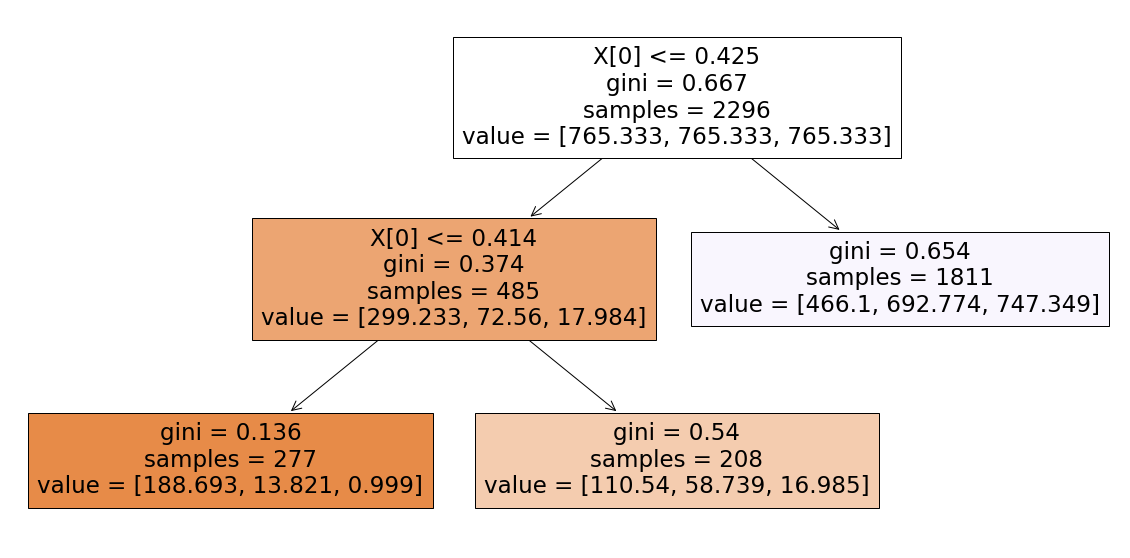

In [41]:
def build_pipeline(params):
    pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          stop_words=params['stop_words'],
                                          ngram_range=(params['ngram_range'][0],params['ngram_range'][1]))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          stop_words=params['stop_words'],
                                          ngram_range=(params['ngram_range'][0],params['ngram_range'][1]))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-utterance',
                                                          conversationKey='dialogue-id',
                                                          windowSize=params['windowSize']))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-utterance',
                                                            conversationKey='dialogue-id',
                                                            windowSize=params['windowSize']))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),

            ('user-turn', Pipeline([
                ('selector', ItemSelector(key='user-index')),
                ('caster', ArrayCaster())
            ])),
             
            ('system-turn', Pipeline([
                ('selector', ItemSelector(key='system-index')),
                ('caster', ArrayCaster())
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', GBR(n_estimators=params['gbr__n_estimators'],
                learning_rate=params['gbr__learning_rate'],
                max_depth=params['gbr__max_depth'],
                random_state=0,
                min_samples_leaf = params['min_samples_leaf']))])
    
    return pipeline


tuned_parameters = {
    'windowSize': 4, 
    'tfidf__min_df': 4, 
    'tfidf__max_df': 0.7697900660077518, 
    'gbr__n_estimators': 50, 
    'gbr__learning_rate': 0.001, 
    'gbr__max_depth': 3, 
    'stop_words': None, 
    'ngram_range': [1, 2], 
    'min_samples_leaf': 0.001
    }
 
pipeline = build_pipeline(tuned_parameters)

pipeline.fit(train, train['class'])

trainPred = pipeline.predict(train)
testPred = pipeline.predict(test)

classifier=DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3, class_weight="balanced", random_state=0)
classifier.fit(trainPred.reshape(-1,1), train['class'].astype(str).values.reshape(-1,1))

predicted = resultArray(classifier, test, testPred.reshape(-1,1))
output = evaluationAsDict(eval_data_path, predicted, 0)

plt.figure(figsize=(20,10)) 
plot_tree(classifier, filled=True) 
plt.show()

In [ ]:
dict = {}
for p in predicted:
    for t in predicted[p]['turns']:
        dict[p + '-' + str(t['turn-index'])]= t['labels'][0]['breakdown']
json.dumps(dict)

'{"iris_DBDC4_114-0": "O", "iris_DBDC4_114-2": "O", "iris_DBDC4_114-4": "X", "iris_DBDC4_114-6": "X", "iris_DBDC4_114-8": "X", "iris_DBDC4_114-10": "X", "iris_DBDC4_114-12": "X", "iris_DBDC4_114-14": "X", "iris_DBDC4_114-16": "X", "iris_DBDC4_114-18": "X", "iris_DBDC4_114-20": "X", "Bot002_072-1": "O", "Bot002_072-3": "O", "Bot002_072-5": "X", "Bot002_072-7": "X", "Bot002_072-9": "X", "Bot002_072-11": "X", "Bot002_072-13": "X", "Bot002_072-15": "X", "Bot002_072-17": "X", "Bot002_072-19": "X", "Bot003_021-0": "O", "Bot003_021-2": "O", "Bot003_021-4": "X", "Bot003_021-6": "X", "Bot003_021-8": "X", "Bot003_021-10": "X", "Bot003_021-12": "X", "Bot003_021-14": "X", "Bot003_021-16": "X", "Bot003_021-18": "X", "Bot003_021-20": "X", "iris_DBDC4_098-0": "O", "iris_DBDC4_098-2": "X", "iris_DBDC4_098-4": "X", "iris_DBDC4_098-6": "X", "iris_DBDC4_098-8": "X", "iris_DBDC4_098-10": "X", "iris_DBDC4_098-12": "X", "iris_DBDC4_098-14": "X", "iris_DBDC4_098-16": "X", "iris_DBDC4_098-18": "X", "iris_DBDC

## Treino

In [ ]:
from tqdm import tqdm
import numpy as np

def build_pipeline(params):
    pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          stop_words=params['stop_words'],
                                          ngram_range=(params['ngram_range'][0],params['ngram_range'][1]))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          stop_words=params['stop_words'],
                                          ngram_range=(params['ngram_range'][0],params['ngram_range'][1]))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-utterance',
                                                          conversationKey='dialogue-id',
                                                          windowSize=params['windowSize']))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-utterance',
                                                            conversationKey='dialogue-id',
                                                            windowSize=params['windowSize']))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),

            ('user-turn', Pipeline([
                ('selector', ItemSelector(key='user-index')),
                ('caster', ArrayCaster())
            ])),
             
            ('system-turn', Pipeline([
                ('selector', ItemSelector(key='system-index')),
                ('caster', ArrayCaster())
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', GBR(n_estimators=params['gbr__n_estimators'],
                learning_rate=params['gbr__learning_rate'],
                max_depth=params['gbr__max_depth'],
                random_state=0,
                min_samples_leaf = params['min_samples_leaf']))])
    
    return pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree

N_ITER = 100

best_model = None
best_classifier = None
best_result = -np.inf
tuned_parameters = None

results_iter = []

for i in tqdm(range(N_ITER)):
  try:
    stop_words_options = ['english',None]
    np.random.shuffle(stop_words_options)

    ngram_range_options = [[1,1],[1,2],[2,2],[1,3],[2,3],[3,3]]
    np.random.shuffle(ngram_range_options)

    parameters = {
          'windowSize': np.random.randint(low=1, high=12),
          'tfidf__min_df': np.random.randint(low=1, high=6),
          'tfidf__max_df': np.random.uniform(low=0.5, high=1.0),
          'gbr__n_estimators': 50,
          'gbr__learning_rate': np.random.choice(np.logspace(-3, -1, 5)),
          'gbr__max_depth': np.random.randint(low=3, high=6),
          'stop_words': stop_words_options[0],
          'ngram_range': ngram_range_options[0],
          'min_samples_leaf' : np.random.choice([0.1,0.05,0.001])
      }
    print(parameters)
    pipeline = build_pipeline(parameters)
    pipeline.fit(train, train['class'])
    
    trainPred = pipeline.predict(train)
    testPred = pipeline.predict(test)
    
    classifier = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3, class_weight="balanced", random_state=0)
    classifier.fit(trainPred.reshape(-1,1),train['class'].astype(str).values.reshape(-1,1))
    trainPred2 = classifier.predict(trainPred.reshape(-1,1))
    testPred2 = classifier.predict(testPred.reshape(-1,1))
    
    predicted = resultArray(classifier, test, testPred.reshape(-1,1))
    output = evaluationAsDict(eval_data_path,predicted,0)
    
    results_iter.append(dict(**parameters,**output,**{"iter":i}))

    if output['f1X']>best_result:
        best_result = output['f1X']
        best_model = pipeline
        best_classifier = classifier
        tuned_parameters = parameters
  except:
      print('error')

print(tuned_parameters)

testPred = best_model.predict(test)
predicted = resultArray(best_classifier, test, testPred.reshape(-1,1))
output = evaluationAsDict(eval_data_path,predicted,0)

  0%|          | 0/100 [00:00<?, ?it/s]

{'windowSize': 8, 'tfidf__min_df': 3, 'tfidf__max_df': 0.7161799483748232, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [1, 2], 'min_samples_leaf': 0.05}


  1%|          | 1/100 [02:14<3:41:53, 134.48s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.455000 (910/2000)

Precision (X) : 	0.290811 (269/925)
Recall    (X) : 	0.559252 (269/481)
F-measure (X) : 	0.382646

Precision (T+X) : 	0.710270 (657/925)
Recall    (T+X) : 	0.516509 (657/1272)
F-measure (T+X) : 	0.598088

JS divergence (O,T,X) : 	0.111833
JS divergence (O,T+X) : 	0.080136
JS divergence (O+T,X) : 	0.065166

Mean squared error (O,T,X) : 	0.062501
Mean squared error (O,T+X) : 	0.094058
Mean squared error (O+T,X) : 	0.065525
###########################
error
{'windowSize': 5, 'tfidf__min_df': 4, 'tfidf__max_df': 0.8782820379152103, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [1, 2], 'min_samples_leaf': 0.1}


  2%|▏         | 2/100 [03:24<3:07:55, 115.05s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.491500 (983/2000)

Precision (X) : 	0.318493 (279/876)
Recall    (X) : 	0.580042 (279/481)
F-measure (X) : 	0.411201

Precision (T+X) : 	0.745434 (653/876)
Recall    (T+X) : 	0.513365 (653/1272)
F-measure (T+X) : 	0.608007

JS divergence (O,T,X) : 	0.109553
JS divergence (O,T+X) : 	0.083800
JS divergence (O+T,X) : 	0.056854

Mean squared error (O,T,X) : 	0.057457
Mean squared error (O,T+X) : 	0.090660
Mean squared error (O+T,X) : 	0.052974
###########################
error
{'windowSize': 2, 'tfidf__min_df': 4, 'tfidf__max_df': 0.6469897713835996, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5, 'stop_words': 'english', 'ngram_range': [2, 2], 'min_samples_leaf': 0.001}


  3%|▎         | 3/100 [04:04<2:29:32, 92.50s/it] 

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.456000 (912/2000)

Precision (X) : 	0.297830 (302/1014)
Recall    (X) : 	0.627859 (302/481)
F-measure (X) : 	0.404013

Precision (T+X) : 	0.714990 (725/1014)
Recall    (T+X) : 	0.569969 (725/1272)
F-measure (T+X) : 	0.634296

JS divergence (O,T,X) : 	0.137436
JS divergence (O,T+X) : 	0.099407
JS divergence (O+T,X) : 	0.081885

Mean squared error (O,T,X) : 	0.074301
Mean squared error (O,T+X) : 	0.114606
Mean squared error (O+T,X) : 	0.079121
###########################
error
{'windowSize': 5, 'tfidf__min_df': 3, 'tfidf__max_df': 0.8038545113407751, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [2, 2], 'min_samples_leaf': 0.05}


  4%|▍         | 4/100 [04:36<1:59:09, 74.47s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.436000 (872/2000)

Precision (X) : 	0.410405 (71/173)
Recall    (X) : 	0.147609 (71/481)
F-measure (X) : 	0.217125

Precision (T+X) : 	0.709738 (758/1068)
Recall    (T+X) : 	0.595912 (758/1272)
F-measure (T+X) : 	0.647863

JS divergence (O,T,X) : 	0.142210
JS divergence (O,T+X) : 	0.099757
JS divergence (O+T,X) : 	0.078974

Mean squared error (O,T,X) : 	0.075924
Mean squared error (O,T+X) : 	0.111467
Mean squared error (O+T,X) : 	0.076800
###########################
error
{'windowSize': 2, 'tfidf__min_df': 2, 'tfidf__max_df': 0.841022118401713, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 4, 'stop_words': None, 'ngram_range': [2, 2], 'min_samples_leaf': 0.05}


  5%|▌         | 5/100 [06:22<2:12:56, 83.96s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.395000 (790/2000)

Precision (X) : 	0.302000 (151/500)
Recall    (X) : 	0.313929 (151/481)
F-measure (X) : 	0.307849

Precision (T+X) : 	0.698054 (897/1285)
Recall    (T+X) : 	0.705189 (897/1272)
F-measure (T+X) : 	0.701603

JS divergence (O,T,X) : 	0.102601
JS divergence (O,T+X) : 	0.074558
JS divergence (O+T,X) : 	0.057546

Mean squared error (O,T,X) : 	0.056645
Mean squared error (O,T+X) : 	0.086749
Mean squared error (O+T,X) : 	0.057855
###########################
error
{'windowSize': 1, 'tfidf__min_df': 5, 'tfidf__max_df': 0.6799968705688422, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4, 'stop_words': None, 'ngram_range': [2, 2], 'min_samples_leaf': 0.05}


  6%|▌         | 6/100 [07:07<1:53:14, 72.28s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.484000 (968/2000)

Precision (X) : 	0.314961 (280/889)
Recall    (X) : 	0.582121 (280/481)
F-measure (X) : 	0.408759

Precision (T+X) : 	0.743532 (661/889)
Recall    (T+X) : 	0.519654 (661/1272)
F-measure (T+X) : 	0.611754

JS divergence (O,T,X) : 	0.111653
JS divergence (O,T+X) : 	0.083536
JS divergence (O+T,X) : 	0.060729

Mean squared error (O,T,X) : 	0.061691
Mean squared error (O,T+X) : 	0.096322
Mean squared error (O+T,X) : 	0.059818
###########################
error
{'windowSize': 6, 'tfidf__min_df': 5, 'tfidf__max_df': 0.8129640490753363, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [3, 3], 'min_samples_leaf': 0.05}


  7%|▋         | 7/100 [07:34<1:31:07, 58.79s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.443000 (886/2000)

Precision (X) : 	0.401786 (90/224)
Recall    (X) : 	0.187110 (90/481)
F-measure (X) : 	0.255319

Precision (T+X) : 	0.725000 (812/1120)
Recall    (T+X) : 	0.638365 (812/1272)
F-measure (T+X) : 	0.678930

JS divergence (O,T,X) : 	0.137917
JS divergence (O,T+X) : 	0.094771
JS divergence (O+T,X) : 	0.078695

Mean squared error (O,T,X) : 	0.073791
Mean squared error (O,T+X) : 	0.104817
Mean squared error (O+T,X) : 	0.078371
###########################
error
{'windowSize': 6, 'tfidf__min_df': 3, 'tfidf__max_df': 0.8462624346869416, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [2, 3], 'min_samples_leaf': 0.001}


  8%|▊         | 8/100 [09:17<1:50:23, 72.00s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.423500 (847/2000)

Precision (X) : 	0.279788 (317/1133)
Recall    (X) : 	0.659044 (317/481)
F-measure (X) : 	0.392813

Precision (T+X) : 	0.691086 (783/1133)
Recall    (T+X) : 	0.615566 (783/1272)
F-measure (T+X) : 	0.651143

JS divergence (O,T,X) : 	0.121467
JS divergence (O,T+X) : 	0.091128
JS divergence (O+T,X) : 	0.068223

Mean squared error (O,T,X) : 	0.065956
Mean squared error (O,T+X) : 	0.103387
Mean squared error (O+T,X) : 	0.064052
###########################
error
{'windowSize': 6, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9352839517660518, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [3, 3], 'min_samples_leaf': 0.001}


  9%|▉         | 9/100 [10:09<1:39:55, 65.88s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.352000 (704/2000)

Precision (X) : 	0.308050 (199/646)
Recall    (X) : 	0.413721 (199/481)
F-measure (X) : 	0.353150

Precision (T+X) : 	0.687301 (1077/1567)
Recall    (T+X) : 	0.846698 (1077/1272)
F-measure (T+X) : 	0.758718

JS divergence (O,T,X) : 	0.094192
JS divergence (O,T+X) : 	0.068147
JS divergence (O+T,X) : 	0.052138

Mean squared error (O,T,X) : 	0.052087
Mean squared error (O,T+X) : 	0.081593
Mean squared error (O+T,X) : 	0.048611
###########################
error
{'windowSize': 2, 'tfidf__min_df': 5, 'tfidf__max_df': 0.5295484107117252, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [2, 2], 'min_samples_leaf': 0.001}


 10%|█         | 10/100 [10:41<1:23:36, 55.74s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.438500 (877/2000)

Precision (X) : 	0.326848 (84/257)
Recall    (X) : 	0.174636 (84/481)
F-measure (X) : 	0.227642

Precision (T+X) : 	0.732759 (765/1044)
Recall    (T+X) : 	0.601415 (765/1272)
F-measure (T+X) : 	0.660622

JS divergence (O,T,X) : 	0.147761
JS divergence (O,T+X) : 	0.097227
JS divergence (O+T,X) : 	0.093636

Mean squared error (O,T,X) : 	0.077372
Mean squared error (O,T+X) : 	0.106200
Mean squared error (O+T,X) : 	0.092844
###########################
error
{'windowSize': 4, 'tfidf__min_df': 4, 'tfidf__max_df': 0.7697900660077518, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [1, 2], 'min_samples_leaf': 0.001}


 11%|█         | 11/100 [12:01<1:33:29, 63.03s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.372000 (744/2000)

Precision (X) : 	0.277706 (431/1552)
Recall    (X) : 	0.896050 (431/481)
F-measure (X) : 	0.424004

Precision (T+X) : 	0.689433 (1070/1552)
Recall    (T+X) : 	0.841195 (1070/1272)
F-measure (T+X) : 	0.757790

JS divergence (O,T,X) : 	0.099782
JS divergence (O,T+X) : 	0.072695
JS divergence (O+T,X) : 	0.056160

Mean squared error (O,T,X) : 	0.054242
Mean squared error (O,T+X) : 	0.085491
Mean squared error (O+T,X) : 	0.049747
###########################
error
{'windowSize': 3, 'tfidf__min_df': 4, 'tfidf__max_df': 0.6203819198519673, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 5, 'stop_words': 'english', 'ngram_range': [1, 3], 'min_samples_leaf': 0.05}


 12%|█▏        | 12/100 [13:03<1:32:01, 62.75s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.436000 (872/2000)

Precision (X) : 	0.306748 (50/163)
Recall    (X) : 	0.103950 (50/481)
F-measure (X) : 	0.155280

Precision (T+X) : 	0.737041 (782/1061)
Recall    (T+X) : 	0.614780 (782/1272)
F-measure (T+X) : 	0.670381

JS divergence (O,T,X) : 	0.121170
JS divergence (O,T+X) : 	0.084884
JS divergence (O+T,X) : 	0.072059

Mean squared error (O,T,X) : 	0.066389
Mean squared error (O,T+X) : 	0.095458
Mean squared error (O+T,X) : 	0.074334
###########################
error
{'windowSize': 6, 'tfidf__min_df': 5, 'tfidf__max_df': 0.8121406194818441, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [1, 1], 'min_samples_leaf': 0.05}


 13%|█▎        | 13/100 [13:47<1:22:54, 57.18s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.424500 (849/2000)

Precision (X) : 	0.341176 (145/425)
Recall    (X) : 	0.301455 (145/481)
F-measure (X) : 	0.320088

Precision (T+X) : 	0.723967 (876/1210)
Recall    (T+X) : 	0.688679 (876/1272)
F-measure (T+X) : 	0.705882

JS divergence (O,T,X) : 	0.107405
JS divergence (O,T+X) : 	0.075836
JS divergence (O+T,X) : 	0.062402

Mean squared error (O,T,X) : 	0.059174
Mean squared error (O,T+X) : 	0.086814
Mean squared error (O+T,X) : 	0.063785
###########################
error
{'windowSize': 1, 'tfidf__min_df': 1, 'tfidf__max_df': 0.75867698651419, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [2, 2], 'min_samples_leaf': 0.1}


 14%|█▍        | 14/100 [15:47<1:48:47, 75.90s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.344500 (689/2000)

Precision (X) : 	0.302941 (206/680)
Recall    (X) : 	0.428274 (206/481)
F-measure (X) : 	0.354866

Precision (T+X) : 	0.682375 (1115/1634)
Recall    (T+X) : 	0.876572 (1115/1272)
F-measure (T+X) : 	0.767378

JS divergence (O,T,X) : 	0.086347
JS divergence (O,T+X) : 	0.060152
JS divergence (O+T,X) : 	0.048451

Mean squared error (O,T,X) : 	0.047264
Mean squared error (O,T+X) : 	0.071353
Mean squared error (O+T,X) : 	0.045948
###########################
error
{'windowSize': 9, 'tfidf__min_df': 2, 'tfidf__max_df': 0.7641974826566815, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [2, 3], 'min_samples_leaf': 0.001}


 15%|█▌        | 15/100 [16:34<1:35:13, 67.22s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.359500 (719/2000)

Precision (X) : 	0.293930 (92/313)
Recall    (X) : 	0.191268 (92/481)
F-measure (X) : 	0.231738

Precision (T+X) : 	0.684844 (967/1412)
Recall    (T+X) : 	0.760220 (967/1272)
F-measure (T+X) : 	0.720566

JS divergence (O,T,X) : 	0.114616
JS divergence (O,T+X) : 	0.080810
JS divergence (O+T,X) : 	0.069051

Mean squared error (O,T,X) : 	0.061890
Mean squared error (O,T+X) : 	0.095311
Mean squared error (O+T,X) : 	0.064821
###########################
error
{'windowSize': 4, 'tfidf__min_df': 5, 'tfidf__max_df': 0.8011497982594697, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5, 'stop_words': 'english', 'ngram_range': [1, 1], 'min_samples_leaf': 0.001}


 16%|█▌        | 16/100 [17:32<1:30:14, 64.46s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.457000 (914/2000)

Precision (X) : 	0.295163 (299/1013)
Recall    (X) : 	0.621622 (299/481)
F-measure (X) : 	0.400268

Precision (T+X) : 	0.722606 (732/1013)
Recall    (T+X) : 	0.575472 (732/1272)
F-measure (T+X) : 	0.640700

JS divergence (O,T,X) : 	0.139334
JS divergence (O,T+X) : 	0.097657
JS divergence (O+T,X) : 	0.084406

Mean squared error (O,T,X) : 	0.073890
Mean squared error (O,T+X) : 	0.112204
Mean squared error (O+T,X) : 	0.078287
###########################
error
{'windowSize': 5, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9815592354058058, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [3, 3], 'min_samples_leaf': 0.1}


 17%|█▋        | 17/100 [17:59<1:13:54, 53.43s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.511000 (1022/2000)

Precision (X) : 	0.335453 (211/629)
Recall    (X) : 	0.438669 (211/481)
F-measure (X) : 	0.380180

Precision (T+X) : 	0.740859 (466/629)
Recall    (T+X) : 	0.366352 (466/1272)
F-measure (T+X) : 	0.490268

JS divergence (O,T,X) : 	0.093762
JS divergence (O,T+X) : 	0.067705
JS divergence (O+T,X) : 	0.051774

Mean squared error (O,T,X) : 	0.051724
Mean squared error (O,T+X) : 	0.079636
Mean squared error (O+T,X) : 	0.048968
###########################
error
{'windowSize': 1, 'tfidf__min_df': 3, 'tfidf__max_df': 0.6276338965163072, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [1, 1], 'min_samples_leaf': 0.001}


 18%|█▊        | 18/100 [19:03<1:16:59, 56.34s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.417000 (834/2000)

Precision (X) : 	0.235075 (63/268)
Recall    (X) : 	0.130977 (63/481)
F-measure (X) : 	0.168224

Precision (T+X) : 	0.722642 (766/1060)
Recall    (T+X) : 	0.602201 (766/1272)
F-measure (T+X) : 	0.656947

JS divergence (O,T,X) : 	0.180624
JS divergence (O,T+X) : 	0.122014
JS divergence (O+T,X) : 	0.107118

Mean squared error (O,T,X) : 	0.099809
Mean squared error (O,T+X) : 	0.131617
Mean squared error (O+T,X) : 	0.107429
###########################
error
{'windowSize': 5, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9969366819479277, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [2, 3], 'min_samples_leaf': 0.1}


 19%|█▉        | 19/100 [19:31<1:04:38, 47.88s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.476000 (952/2000)

Precision (X) : 	0.306522 (282/920)
Recall    (X) : 	0.586279 (282/481)
F-measure (X) : 	0.402570

Precision (T+X) : 	0.723913 (666/920)
Recall    (T+X) : 	0.523585 (666/1272)
F-measure (T+X) : 	0.607664

JS divergence (O,T,X) : 	0.099585
JS divergence (O,T+X) : 	0.073020
JS divergence (O+T,X) : 	0.055399

Mean squared error (O,T,X) : 	0.054342
Mean squared error (O,T+X) : 	0.084662
Mean squared error (O+T,X) : 	0.051223
###########################
error
{'windowSize': 9, 'tfidf__min_df': 4, 'tfidf__max_df': 0.989950318508209, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [1, 2], 'min_samples_leaf': 0.001}


 20%|██        | 20/100 [21:33<1:33:34, 70.19s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.340000 (680/2000)

Precision (X) : 	0.288000 (216/750)
Recall    (X) : 	0.449064 (216/481)
F-measure (X) : 	0.350934

Precision (T+X) : 	0.685197 (1097/1601)
Recall    (T+X) : 	0.862421 (1097/1272)
F-measure (T+X) : 	0.763662

JS divergence (O,T,X) : 	0.149268
JS divergence (O,T+X) : 	0.109659
JS divergence (O+T,X) : 	0.086237

Mean squared error (O,T,X) : 	0.080183
Mean squared error (O,T+X) : 	0.119618
Mean squared error (O+T,X) : 	0.085289
###########################
error
{'windowSize': 2, 'tfidf__min_df': 1, 'tfidf__max_df': 0.6394575537427543, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [3, 3], 'min_samples_leaf': 0.1}


 21%|██        | 21/100 [23:01<1:39:29, 75.56s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.436500 (873/2000)

Precision (X) : 	0.300733 (369/1227)
Recall    (X) : 	0.767152 (369/481)
F-measure (X) : 	0.432084

Precision (T+X) : 	0.705786 (866/1227)
Recall    (T+X) : 	0.680818 (866/1272)
F-measure (T+X) : 	0.693077

JS divergence (O,T,X) : 	0.097091
JS divergence (O,T+X) : 	0.070564
JS divergence (O+T,X) : 	0.054484

Mean squared error (O,T,X) : 	0.053565
Mean squared error (O,T+X) : 	0.083786
Mean squared error (O+T,X) : 	0.050365
###########################
error
{'windowSize': 1, 'tfidf__min_df': 5, 'tfidf__max_df': 0.8714809394088743, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [3, 3], 'min_samples_leaf': 0.05}


 22%|██▏       | 22/100 [23:28<1:19:11, 60.91s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.436000 (872/2000)

Precision (X) : 	0.306000 (153/500)
Recall    (X) : 	0.318087 (153/481)
F-measure (X) : 	0.311927

Precision (T+X) : 	0.723164 (768/1062)
Recall    (T+X) : 	0.603774 (768/1272)
F-measure (T+X) : 	0.658098

JS divergence (O,T,X) : 	0.133433
JS divergence (O,T+X) : 	0.095467
JS divergence (O+T,X) : 	0.078923

Mean squared error (O,T,X) : 	0.072394
Mean squared error (O,T+X) : 	0.104707
Mean squared error (O+T,X) : 	0.083540
###########################
error
{'windowSize': 11, 'tfidf__min_df': 3, 'tfidf__max_df': 0.6045644617915629, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 3, 'stop_words': 'english', 'ngram_range': [2, 3], 'min_samples_leaf': 0.05}


 23%|██▎       | 23/100 [23:55<1:05:18, 50.89s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.412500 (825/2000)

Precision (X) : 	0.276224 (316/1144)
Recall    (X) : 	0.656965 (316/481)
F-measure (X) : 	0.388923

Precision (T+X) : 	0.683566 (782/1144)
Recall    (T+X) : 	0.614780 (782/1272)
F-measure (T+X) : 	0.647351

JS divergence (O,T,X) : 	0.097303
JS divergence (O,T+X) : 	0.069913
JS divergence (O+T,X) : 	0.055249

Mean squared error (O,T,X) : 	0.053307
Mean squared error (O,T+X) : 	0.081833
Mean squared error (O+T,X) : 	0.050829
###########################
error
{'windowSize': 5, 'tfidf__min_df': 4, 'tfidf__max_df': 0.5578499339733056, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [2, 3], 'min_samples_leaf': 0.1}


 24%|██▍       | 24/100 [24:49<1:05:41, 51.86s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.436500 (873/2000)

Precision (X) : 	0.341398 (127/372)
Recall    (X) : 	0.264033 (127/481)
F-measure (X) : 	0.297773

Precision (T+X) : 	0.719751 (809/1124)
Recall    (T+X) : 	0.636006 (809/1272)
F-measure (T+X) : 	0.675292

JS divergence (O,T,X) : 	0.142450
JS divergence (O,T+X) : 	0.102382
JS divergence (O+T,X) : 	0.080999

Mean squared error (O,T,X) : 	0.078500
Mean squared error (O,T+X) : 	0.113860
Mean squared error (O+T,X) : 	0.081433
###########################
error
{'windowSize': 2, 'tfidf__min_df': 5, 'tfidf__max_df': 0.6386668935804902, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [1, 1], 'min_samples_leaf': 0.05}


 25%|██▌       | 25/100 [25:34<1:02:04, 49.66s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.431500 (863/2000)

Precision (X) : 	0.312741 (162/518)
Recall    (X) : 	0.336798 (162/481)
F-measure (X) : 	0.324324

Precision (T+X) : 	0.722222 (767/1062)
Recall    (T+X) : 	0.602987 (767/1272)
F-measure (T+X) : 	0.657241

JS divergence (O,T,X) : 	0.119405
JS divergence (O,T+X) : 	0.082819
JS divergence (O+T,X) : 	0.072827

Mean squared error (O,T,X) : 	0.066684
Mean squared error (O,T+X) : 	0.093732
Mean squared error (O+T,X) : 	0.077621
###########################
error
{'windowSize': 3, 'tfidf__min_df': 5, 'tfidf__max_df': 0.5144857059078727, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4, 'stop_words': None, 'ngram_range': [2, 2], 'min_samples_leaf': 0.001}


 26%|██▌       | 26/100 [26:24<1:01:27, 49.83s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.448000 (896/2000)

Precision (X) : 	0.329545 (58/176)
Recall    (X) : 	0.120582 (58/481)
F-measure (X) : 	0.176560

Precision (T+X) : 	0.727564 (681/936)
Recall    (T+X) : 	0.535377 (681/1272)
F-measure (T+X) : 	0.616848

JS divergence (O,T,X) : 	0.138654
JS divergence (O,T+X) : 	0.093143
JS divergence (O+T,X) : 	0.084577

Mean squared error (O,T,X) : 	0.073085
Mean squared error (O,T+X) : 	0.101800
Mean squared error (O+T,X) : 	0.085112
###########################
error
{'windowSize': 8, 'tfidf__min_df': 5, 'tfidf__max_df': 0.8359036996102176, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [1, 1], 'min_samples_leaf': 0.05}


 27%|██▋       | 27/100 [27:27<1:05:18, 53.68s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.438500 (877/2000)

Precision (X) : 	0.279612 (288/1030)
Recall    (X) : 	0.598753 (288/481)
F-measure (X) : 	0.381205

Precision (T+X) : 	0.700971 (722/1030)
Recall    (T+X) : 	0.567610 (722/1272)
F-measure (T+X) : 	0.627281

JS divergence (O,T,X) : 	0.104205
JS divergence (O,T+X) : 	0.076932
JS divergence (O+T,X) : 	0.057833

Mean squared error (O,T,X) : 	0.057572
Mean squared error (O,T+X) : 	0.090113
Mean squared error (O+T,X) : 	0.054638
###########################
error
{'windowSize': 10, 'tfidf__min_df': 3, 'tfidf__max_df': 0.8563049293515621, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 5, 'stop_words': 'english', 'ngram_range': [2, 3], 'min_samples_leaf': 0.05}


 28%|██▊       | 28/100 [28:04<58:17, 48.58s/it]  

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.470000 (940/2000)

Precision (X) : 	0.303922 (279/918)
Recall    (X) : 	0.580042 (279/481)
F-measure (X) : 	0.398856

Precision (T+X) : 	0.726580 (667/918)
Recall    (T+X) : 	0.524371 (667/1272)
F-measure (T+X) : 	0.609132

JS divergence (O,T,X) : 	0.123426
JS divergence (O,T+X) : 	0.087612
JS divergence (O+T,X) : 	0.073135

Mean squared error (O,T,X) : 	0.068421
Mean squared error (O,T+X) : 	0.101137
Mean squared error (O+T,X) : 	0.072843
###########################
error
{'windowSize': 4, 'tfidf__min_df': 5, 'tfidf__max_df': 0.6016540232965016, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [2, 2], 'min_samples_leaf': 0.001}


 29%|██▉       | 29/100 [29:04<1:01:31, 51.99s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.382000 (764/2000)

Precision (X) : 	0.329939 (162/491)
Recall    (X) : 	0.336798 (162/481)
F-measure (X) : 	0.333333

Precision (T+X) : 	0.697297 (1032/1480)
Recall    (T+X) : 	0.811321 (1032/1272)
F-measure (T+X) : 	0.750000

JS divergence (O,T,X) : 	0.185280
JS divergence (O,T+X) : 	0.117656
JS divergence (O+T,X) : 	0.114769

Mean squared error (O,T,X) : 	0.101399
Mean squared error (O,T+X) : 	0.122476
Mean squared error (O+T,X) : 	0.113313
###########################
error
{'windowSize': 8, 'tfidf__min_df': 5, 'tfidf__max_df': 0.6814851156395264, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [1, 3], 'min_samples_leaf': 0.05}


 30%|███       | 30/100 [30:12<1:06:29, 56.99s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.392000 (784/2000)

Precision (X) : 	0.312210 (202/647)
Recall    (X) : 	0.419958 (202/481)
F-measure (X) : 	0.358156

Precision (T+X) : 	0.701669 (1009/1438)
Recall    (T+X) : 	0.793239 (1009/1272)
F-measure (T+X) : 	0.744649

JS divergence (O,T,X) : 	0.105057
JS divergence (O,T+X) : 	0.074874
JS divergence (O+T,X) : 	0.060247

Mean squared error (O,T,X) : 	0.058404
Mean squared error (O,T+X) : 	0.086782
Mean squared error (O+T,X) : 	0.061330
###########################
error
{'windowSize': 3, 'tfidf__min_df': 4, 'tfidf__max_df': 0.791138438291979, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3, 'stop_words': 'english', 'ngram_range': [2, 3], 'min_samples_leaf': 0.05}


 31%|███       | 31/100 [30:38<54:37, 47.50s/it]  

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.419000 (838/2000)

Precision (X) : 	0.284689 (357/1254)
Recall    (X) : 	0.742204 (357/481)
F-measure (X) : 	0.411527

Precision (T+X) : 	0.709729 (890/1254)
Recall    (T+X) : 	0.699686 (890/1272)
F-measure (T+X) : 	0.704671

JS divergence (O,T,X) : 	0.106497
JS divergence (O,T+X) : 	0.078211
JS divergence (O+T,X) : 	0.059663

Mean squared error (O,T,X) : 	0.058759
Mean squared error (O,T+X) : 	0.091485
Mean squared error (O+T,X) : 	0.056600
###########################
error
{'windowSize': 9, 'tfidf__min_df': 5, 'tfidf__max_df': 0.6954509057927905, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [2, 2], 'min_samples_leaf': 0.1}


 32%|███▏      | 32/100 [31:19<51:42, 45.62s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.464500 (929/2000)

Precision (X) : 	0.285006 (230/807)
Recall    (X) : 	0.478170 (230/481)
F-measure (X) : 	0.357143

Precision (T+X) : 	0.714994 (577/807)
Recall    (T+X) : 	0.453616 (577/1272)
F-measure (T+X) : 	0.555075

JS divergence (O,T,X) : 	0.098099
JS divergence (O,T+X) : 	0.072033
JS divergence (O+T,X) : 	0.053416

Mean squared error (O,T,X) : 	0.053874
Mean squared error (O,T+X) : 	0.083418
Mean squared error (O+T,X) : 	0.050416
###########################
error
{'windowSize': 7, 'tfidf__min_df': 1, 'tfidf__max_df': 0.7034703401484818, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 4, 'stop_words': None, 'ngram_range': [3, 3], 'min_samples_leaf': 0.1}


 33%|███▎      | 33/100 [34:02<1:30:12, 80.78s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.461000 (922/2000)

Precision (X) : 	0.272956 (217/795)
Recall    (X) : 	0.451143 (217/481)
F-measure (X) : 	0.340125

Precision (T+X) : 	0.727044 (578/795)
Recall    (T+X) : 	0.454403 (578/1272)
F-measure (T+X) : 	0.559265

JS divergence (O,T,X) : 	0.096715
JS divergence (O,T+X) : 	0.068796
JS divergence (O+T,X) : 	0.055758

Mean squared error (O,T,X) : 	0.052927
Mean squared error (O,T+X) : 	0.080600
Mean squared error (O+T,X) : 	0.051855
###########################
error
{'windowSize': 9, 'tfidf__min_df': 3, 'tfidf__max_df': 0.7130896041266147, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [1, 1], 'min_samples_leaf': 0.001}


 34%|███▍      | 34/100 [35:38<1:34:08, 85.59s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.374000 (748/2000)

Precision (X) : 	0.301075 (56/186)
Recall    (X) : 	0.116424 (56/481)
F-measure (X) : 	0.167916

Precision (T+X) : 	0.704735 (1012/1436)
Recall    (T+X) : 	0.795597 (1012/1272)
F-measure (T+X) : 	0.747415

JS divergence (O,T,X) : 	0.325870
JS divergence (O,T+X) : 	0.195966
JS divergence (O+T,X) : 	0.147573

Mean squared error (O,T,X) : 	0.197075
Mean squared error (O,T+X) : 	0.193096
Mean squared error (O+T,X) : 	0.130811
###########################
error
{'windowSize': 5, 'tfidf__min_df': 1, 'tfidf__max_df': 0.8542968361314377, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5, 'stop_words': 'english', 'ngram_range': [2, 2], 'min_samples_leaf': 0.001}


 35%|███▌      | 35/100 [38:38<2:03:10, 113.71s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.375000 (750/2000)

Precision (X) : 	0.277228 (28/101)
Recall    (X) : 	0.058212 (28/481)
F-measure (X) : 	0.096220

Precision (T+X) : 	0.691649 (969/1401)
Recall    (T+X) : 	0.761792 (969/1272)
F-measure (T+X) : 	0.725028

JS divergence (O,T,X) : 	0.234788
JS divergence (O,T+X) : 	0.153640
JS divergence (O+T,X) : 	0.099595

Mean squared error (O,T,X) : 	0.145942
Mean squared error (O,T+X) : 	0.167636
Mean squared error (O+T,X) : 	0.091305
###########################
error
{'windowSize': 9, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9310388212144107, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4, 'stop_words': None, 'ngram_range': [2, 2], 'min_samples_leaf': 0.1}


 36%|███▌      | 36/100 [39:35<1:43:12, 96.76s/it] 

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.362500 (725/2000)

Precision (X) : 	0.281593 (205/728)
Recall    (X) : 	0.426195 (205/481)
F-measure (X) : 	0.339123

Precision (T+X) : 	0.685135 (1014/1480)
Recall    (T+X) : 	0.797170 (1014/1272)
F-measure (T+X) : 	0.736919

JS divergence (O,T,X) : 	0.089301
JS divergence (O,T+X) : 	0.062051
JS divergence (O+T,X) : 	0.051634

Mean squared error (O,T,X) : 	0.048439
Mean squared error (O,T+X) : 	0.073424
Mean squared error (O+T,X) : 	0.049222
###########################
error
{'windowSize': 10, 'tfidf__min_df': 3, 'tfidf__max_df': 0.502074170326949, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4, 'stop_words': None, 'ngram_range': [1, 2], 'min_samples_leaf': 0.05}


 37%|███▋      | 37/100 [41:31<1:47:43, 102.60s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.487500 (975/2000)

Precision (X) : 	0.306598 (237/773)
Recall    (X) : 	0.492723 (237/481)
F-measure (X) : 	0.377990

Precision (T+X) : 	0.742561 (574/773)
Recall    (T+X) : 	0.451258 (574/1272)
F-measure (T+X) : 	0.561369

JS divergence (O,T,X) : 	0.121372
JS divergence (O,T+X) : 	0.087818
JS divergence (O+T,X) : 	0.069897

Mean squared error (O,T,X) : 	0.065916
Mean squared error (O,T+X) : 	0.098722
Mean squared error (O+T,X) : 	0.070784
###########################
error
{'windowSize': 8, 'tfidf__min_df': 3, 'tfidf__max_df': 0.6605341166217906, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [1, 1], 'min_samples_leaf': 0.05}


 38%|███▊      | 38/100 [42:29<1:32:08, 89.18s/it] 

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.459000 (918/2000)

Precision (X) : 	0.319865 (95/297)
Recall    (X) : 	0.197505 (95/481)
F-measure (X) : 	0.244216

Precision (T+X) : 	0.744875 (654/878)
Recall    (T+X) : 	0.514151 (654/1272)
F-measure (T+X) : 	0.608372

JS divergence (O,T,X) : 	0.160963
JS divergence (O,T+X) : 	0.102588
JS divergence (O+T,X) : 	0.100994

Mean squared error (O,T,X) : 	0.083154
Mean squared error (O,T+X) : 	0.109546
Mean squared error (O+T,X) : 	0.098956
###########################
error
{'windowSize': 3, 'tfidf__min_df': 3, 'tfidf__max_df': 0.6408100365875222, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'stop_words': 'english', 'ngram_range': [1, 1], 'min_samples_leaf': 0.05}


 39%|███▉      | 39/100 [43:16<1:17:50, 76.57s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.425500 (851/2000)

Precision (X) : 	0.337104 (149/442)
Recall    (X) : 	0.309771 (149/481)
F-measure (X) : 	0.322860

Precision (T+X) : 	0.712020 (853/1198)
Recall    (T+X) : 	0.670597 (853/1272)
F-measure (T+X) : 	0.690688

JS divergence (O,T,X) : 	0.138682
JS divergence (O,T+X) : 	0.098439
JS divergence (O+T,X) : 	0.082151

Mean squared error (O,T,X) : 	0.075265
Mean squared error (O,T+X) : 	0.110894
Mean squared error (O+T,X) : 	0.081877
###########################
error
{'windowSize': 3, 'tfidf__min_df': 5, 'tfidf__max_df': 0.6172508447798389, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3, 'stop_words': 'english', 'ngram_range': [1, 3], 'min_samples_leaf': 0.001}


 40%|████      | 40/100 [43:58<1:06:13, 66.23s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.430500 (861/2000)

Precision (X) : 	0.347741 (177/509)
Recall    (X) : 	0.367983 (177/481)
F-measure (X) : 	0.357576

Precision (T+X) : 	0.724778 (898/1239)
Recall    (T+X) : 	0.705975 (898/1272)
F-measure (T+X) : 	0.715253

JS divergence (O,T,X) : 	0.108184
JS divergence (O,T+X) : 	0.075274
JS divergence (O+T,X) : 	0.064622

Mean squared error (O,T,X) : 	0.059097
Mean squared error (O,T+X) : 	0.086759
Mean squared error (O+T,X) : 	0.064933
###########################
error
{'windowSize': 10, 'tfidf__min_df': 5, 'tfidf__max_df': 0.8214897029561048, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'stop_words': 'english', 'ngram_range': [2, 3], 'min_samples_leaf': 0.001}


 41%|████      | 41/100 [44:24<53:08, 54.05s/it]  

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.362000 (724/2000)

Precision (X) : 	0.301111 (271/900)
Recall    (X) : 	0.563410 (271/481)
F-measure (X) : 	0.392469

Precision (T+X) : 	0.687342 (1086/1580)
Recall    (T+X) : 	0.853774 (1086/1272)
F-measure (T+X) : 	0.761571

JS divergence (O,T,X) : 	0.156671
JS divergence (O,T+X) : 	0.111926
JS divergence (O+T,X) : 	0.092054

Mean squared error (O,T,X) : 	0.083390
Mean squared error (O,T+X) : 	0.122499
Mean squared error (O+T,X) : 	0.088935
###########################
error
{'windowSize': 3, 'tfidf__min_df': 3, 'tfidf__max_df': 0.9847243420518106, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 3, 'stop_words': 'english', 'ngram_range': [2, 3], 'min_samples_leaf': 0.001}


 42%|████▏     | 42/100 [44:53<44:57, 46.51s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.413500 (827/2000)

Precision (X) : 	0.376812 (104/276)
Recall    (X) : 	0.216216 (104/481)
F-measure (X) : 	0.274769

Precision (T+X) : 	0.708831 (891/1257)
Recall    (T+X) : 	0.700472 (891/1272)
F-measure (T+X) : 	0.704626

JS divergence (O,T,X) : 	0.111333
JS divergence (O,T+X) : 	0.077659
JS divergence (O+T,X) : 	0.067265

Mean squared error (O,T,X) : 	0.061349
Mean squared error (O,T+X) : 	0.090639
Mean squared error (O+T,X) : 	0.067657
###########################
error
{'windowSize': 4, 'tfidf__min_df': 4, 'tfidf__max_df': 0.7304802677447517, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5, 'stop_words': 'english', 'ngram_range': [1, 3], 'min_samples_leaf': 0.001}


 43%|████▎     | 43/100 [46:06<51:52, 54.61s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.411000 (822/2000)

Precision (X) : 	0.275943 (351/1272)
Recall    (X) : 	0.729730 (351/481)
F-measure (X) : 	0.400456

Precision (T+X) : 	0.699686 (890/1272)
Recall    (T+X) : 	0.699686 (890/1272)
F-measure (T+X) : 	0.699686

JS divergence (O,T,X) : 	0.118701
JS divergence (O,T+X) : 	0.084774
JS divergence (O+T,X) : 	0.070490

Mean squared error (O,T,X) : 	0.064679
Mean squared error (O,T+X) : 	0.101178
Mean squared error (O+T,X) : 	0.064336
###########################
error
{'windowSize': 7, 'tfidf__min_df': 1, 'tfidf__max_df': 0.5502025041123568, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [2, 2], 'min_samples_leaf': 0.001}


 44%|████▍     | 44/100 [50:14<1:45:08, 112.65s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.373500 (747/2000)

Precision (X) : 	0.290520 (190/654)
Recall    (X) : 	0.395010 (190/481)
F-measure (X) : 	0.334802

Precision (T+X) : 	0.694209 (983/1416)
Recall    (T+X) : 	0.772799 (983/1272)
F-measure (T+X) : 	0.731399

JS divergence (O,T,X) : 	0.159139
JS divergence (O,T+X) : 	0.106545
JS divergence (O+T,X) : 	0.098366

Mean squared error (O,T,X) : 	0.087245
Mean squared error (O,T+X) : 	0.120749
Mean squared error (O+T,X) : 	0.093917
###########################
error
{'windowSize': 4, 'tfidf__min_df': 4, 'tfidf__max_df': 0.8799634938408383, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [2, 3], 'min_samples_leaf': 0.1}


 45%|████▌     | 45/100 [51:11<1:27:49, 95.81s/it] 

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.406500 (813/2000)

Precision (X) : 	0.313343 (209/667)
Recall    (X) : 	0.434511 (209/481)
F-measure (X) : 	0.364111

Precision (T+X) : 	0.688722 (916/1330)
Recall    (T+X) : 	0.720126 (916/1272)
F-measure (T+X) : 	0.704074

JS divergence (O,T,X) : 	0.090192
JS divergence (O,T+X) : 	0.063859
JS divergence (O+T,X) : 	0.050034

Mean squared error (O,T,X) : 	0.050005
Mean squared error (O,T+X) : 	0.076199
Mean squared error (O+T,X) : 	0.048231
###########################
error
{'windowSize': 1, 'tfidf__min_df': 2, 'tfidf__max_df': 0.9003192412006049, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [1, 3], 'min_samples_leaf': 0.001}


 46%|████▌     | 46/100 [53:04<1:30:58, 101.09s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.393500 (787/2000)

Precision (X) : 	0.339934 (103/303)
Recall    (X) : 	0.214137 (103/481)
F-measure (X) : 	0.262755

Precision (T+X) : 	0.708851 (969/1367)
Recall    (T+X) : 	0.761792 (969/1272)
F-measure (T+X) : 	0.734369

JS divergence (O,T,X) : 	0.228960
JS divergence (O,T+X) : 	0.140392
JS divergence (O+T,X) : 	0.130221

Mean squared error (O,T,X) : 	0.137929
Mean squared error (O,T+X) : 	0.150374
Mean squared error (O+T,X) : 	0.124677
###########################
error
{'windowSize': 8, 'tfidf__min_df': 1, 'tfidf__max_df': 0.5814512095937893, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [3, 3], 'min_samples_leaf': 0.05}


 47%|████▋     | 47/100 [56:20<1:54:16, 129.36s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.449000 (898/2000)

Precision (X) : 	0.287698 (290/1008)
Recall    (X) : 	0.602911 (290/481)
F-measure (X) : 	0.389523

Precision (T+X) : 	0.708333 (714/1008)
Recall    (T+X) : 	0.561321 (714/1272)
F-measure (T+X) : 	0.626316

JS divergence (O,T,X) : 	0.123724
JS divergence (O,T+X) : 	0.095978
JS divergence (O+T,X) : 	0.066058

Mean squared error (O,T,X) : 	0.065910
Mean squared error (O,T+X) : 	0.104813
Mean squared error (O+T,X) : 	0.061730
###########################
error
{'windowSize': 1, 'tfidf__min_df': 3, 'tfidf__max_df': 0.7079403610812101, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [1, 2], 'min_samples_leaf': 0.1}


 48%|████▊     | 48/100 [57:48<1:41:32, 117.17s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.449000 (898/2000)

Precision (X) : 	0.301587 (57/189)
Recall    (X) : 	0.118503 (57/481)
F-measure (X) : 	0.170149

Precision (T+X) : 	0.730727 (673/921)
Recall    (T+X) : 	0.529088 (673/1272)
F-measure (T+X) : 	0.613771

JS divergence (O,T,X) : 	0.127012
JS divergence (O,T+X) : 	0.088491
JS divergence (O+T,X) : 	0.075264

Mean squared error (O,T,X) : 	0.068954
Mean squared error (O,T+X) : 	0.098441
Mean squared error (O+T,X) : 	0.077512
###########################
error
{'windowSize': 5, 'tfidf__min_df': 3, 'tfidf__max_df': 0.8391350708823304, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [1, 2], 'min_samples_leaf': 0.001}


 49%|████▉     | 49/100 [59:31<1:35:47, 112.69s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.376000 (752/2000)

Precision (X) : 	0.337761 (178/527)
Recall    (X) : 	0.370062 (178/481)
F-measure (X) : 	0.353175

Precision (T+X) : 	0.692715 (1046/1510)
Recall    (T+X) : 	0.822327 (1046/1272)
F-measure (T+X) : 	0.751977

JS divergence (O,T,X) : 	0.099787
JS divergence (O,T+X) : 	0.069581
JS divergence (O+T,X) : 	0.059060

Mean squared error (O,T,X) : 	0.054242
Mean squared error (O,T+X) : 	0.082894
Mean squared error (O+T,X) : 	0.055073
###########################
error
{'windowSize': 7, 'tfidf__min_df': 2, 'tfidf__max_df': 0.5462200765108354, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [2, 2], 'min_samples_leaf': 0.1}


 50%|█████     | 50/100 [1:00:07<1:14:48, 89.77s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.430500 (861/2000)

Precision (X) : 	0.377451 (77/204)
Recall    (X) : 	0.160083 (77/481)
F-measure (X) : 	0.224818

Precision (T+X) : 	0.713137 (798/1119)
Recall    (T+X) : 	0.627358 (798/1272)
F-measure (T+X) : 	0.667503

JS divergence (O,T,X) : 	0.125620
JS divergence (O,T+X) : 	0.086458
JS divergence (O+T,X) : 	0.075786

Mean squared error (O,T,X) : 	0.068074
Mean squared error (O,T+X) : 	0.098640
Mean squared error (O+T,X) : 	0.075263
###########################
error
{'windowSize': 4, 'tfidf__min_df': 3, 'tfidf__max_df': 0.7214028555188996, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 4, 'stop_words': None, 'ngram_range': [3, 3], 'min_samples_leaf': 0.05}


 51%|█████     | 51/100 [1:00:46<1:00:59, 74.69s/it]

######### Data Stats #########
File Num : 		200
System Utterance Num : 	2000
O Label Num : 		1073
T Label Num : 		446
X Label Num : 		481

######### Results #########
Accuracy : 		0.419500 (839/2000)

Precision (X) : 	0.345013 (128/371)
Recall    (X) : 	0.266112 (128/481)
F-measure (X) : 	0.300469

Precision (T+X) : 	0.718274 (849/1182)
Recall    (T+X) : 	0.667453 (849/1272)
F-measure (T+X) : 	0.691932

JS divergence (O,T,X) : 	0.109144
JS divergence (O,T+X) : 	0.075925
JS divergence (O+T,X) : 	0.064429

Mean squared error (O,T,X) : 	0.059790
Mean squared error (O,T+X) : 	0.085994
Mean squared error (O+T,X) : 	0.066238
###########################
error
{'windowSize': 1, 'tfidf__min_df': 5, 'tfidf__max_df': 0.5273950980682041, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3, 'stop_words': 'english', 'ngram_range': [3, 3], 'min_samples_leaf': 0.001}


 52%|█████▏    | 52/100 [1:00:50<42:43, 53.41s/it]  

error
{'windowSize': 3, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9120753838118367, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.01, 'gbr__max_depth': 3, 'stop_words': 'english', 'ngram_range': [1, 1], 'min_samples_leaf': 0.1}


 53%|█████▎    | 53/100 [1:00:56<30:41, 39.19s/it]

error
{'windowSize': 5, 'tfidf__min_df': 1, 'tfidf__max_df': 0.9862092897182809, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [1, 3], 'min_samples_leaf': 0.05}


 54%|█████▍    | 54/100 [1:01:28<28:27, 37.12s/it]

error
{'windowSize': 7, 'tfidf__min_df': 5, 'tfidf__max_df': 0.7656479547447579, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4, 'stop_words': None, 'ngram_range': [1, 3], 'min_samples_leaf': 0.1}


 55%|█████▌    | 55/100 [1:01:33<20:36, 27.47s/it]

error
{'windowSize': 9, 'tfidf__min_df': 5, 'tfidf__max_df': 0.8658781362646764, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 5, 'stop_words': None, 'ngram_range': [3, 3], 'min_samples_leaf': 0.1}


 56%|█████▌    | 56/100 [1:01:38<15:01, 20.50s/it]

error
{'windowSize': 10, 'tfidf__min_df': 5, 'tfidf__max_df': 0.9518284663495414, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [1, 1], 'min_samples_leaf': 0.001}


 57%|█████▋    | 57/100 [1:01:47<12:17, 17.16s/it]

error
{'windowSize': 6, 'tfidf__min_df': 5, 'tfidf__max_df': 0.6904944568160011, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.001, 'gbr__max_depth': 4, 'stop_words': 'english', 'ngram_range': [1, 3], 'min_samples_leaf': 0.1}


In [ ]:
def saveDictionaryAsJson(outputPath, fileName, data):
    fileToSave = pathjoin(outputPath, fileName)
    with open(fileToSave, 'w') as file:
        #print(data)
        file.write(json.dumps(data))

In [ ]:
pd.DataFrame(results_iter)['f1X'].max()

0.30975954738330974

In [ ]:
print(results_iter)

[{'windowSize': 5, 'tfidf__min_df': 5, 'tfidf__max_df': 0.8804579664308068, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.0031622776601683794, 'gbr__max_depth': 3, 'stop_words': None, 'ngram_range': [3, 3], 'fileNumber': 200, 'systemUtterance': 2000, 'ansO': 1507, 'ansT': 187, 'ansX': 306, 'accuracy': 0.4675, 'precisionX': 0.19346289752650175, 'predX_ansX': 219, 'total_predX': 1132, 'total_ansX': 306, 'recallX': 0.7156862745098039, 'f1X': 0.30458970792767737, 'precisionTX': 0.7022968197879859, 'recallTX': 0.625, 'f1TX': 0.6613976705490848, 'totalTXAnsX': 795, 'totalPredX+PredT': 1132, 'totalAnsX': 1272, 'js-O-T-X': 0.10129979680982411, 'js-O-T+X': 0.07564913789037647, 'js-O+T-X': 0.053645647291766525, 'mse-O-T-X': 0.0548367023200051, 'mse-O-T+X': 0.08544918079317937, 'mse-O+T-X': 0.048994869261499166, 'iter': 0}, {'windowSize': 9, 'tfidf__min_df': 4, 'tfidf__max_df': 0.6582940911096039, 'gbr__n_estimators': 50, 'gbr__learning_rate': 0.1, 'gbr__max_depth': 4, 'stop_words': 'english',

## Computa os valores de Teste

In [ ]:
dict_test = {}
for index,row in test.iterrows():
    if not isinstance(row['classCHAR'],float):
        dict_test[row['dialogue-id']+'-'+str(row['system-index'])] = row['classCHAR']
    else:
        dict_test[row['dialogue-id']+'-'+str(row['system-index'])] = 'O'
#dict_test
saveDictionaryAsJson('C:/Users/leona/Dropbox/python/teste_estatistico/','ENG-test.json',dict_test)

In [ ]:
dict = {}
for p in predicted:
    for t in predicted[p]['turns']:
        dict[p + '-' + str(t['turn-index'])]= t['labels'][0]['breakdown']        
saveDictionaryAsJson('C:/Users/leona/Dropbox/python/teste_estatistico/','ENG-REGw2v.json',dict)

## Sujeiras

In [ ]:
pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=4,max_df=0.92,ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=4,max_df=0.92,ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-utterance',conversationKey='dialogue-id',windowSize=5))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-utterance',conversationKey='dialogue-id',windowSize=5))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),

            ('user-turn', Pipeline([
                ('selector', ItemSelector(key='user-index')),
                ('caster', ArrayCaster())
            ])),
             
            ('system-turn', Pipeline([
                ('selector', ItemSelector(key='system-index')),
                ('caster', ArrayCaster())
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', gbr)
    #('clf', model)
     #neural_network.MLPRegressor(random_state=42, max_iter=500))
    #linear_model.ElasticNetCV(random_state=42)
])

# Analisa o resultado (classification report) deste pipeline com um único regressor, dar o nome para pipelineEmbedding
# Criar outro pipeline com outra feature
# Salvar o resultado o esperado e o resultado predito de cada modelo
# output disso cria-se uma arvore de decisao como X da arvore

tuned_parameters = [{#'union__user-utterance-vector__userWindowSelector__windowSize':[5,10,15],
                     #'union__system-utterance-vector__systemWindowSelector__windowSize':[5,10,15],
                     'clf__regressors': [(rfr, ridge, lasso, lr), 
                                         (rfr, gbr, xgr)]
                    }
                   ]

In [ ]:
pipeline.fit(train, train['class'])
trainPred = pipeline.predict(train)
testPred = pipeline.predict(test)

In [ ]:
#classifier= linear_model.LogisticRegressionCV().fit(trainPred.reshape(-1,1),train['class'].astype(str).values.reshape(-1,1))
classifier=DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3).fit(trainPred.reshape(-1,1),train['class'].astype(str).values.reshape(-1,1))
trainPred2 = classifier.predict(trainPred.reshape(-1,1))
testPred2 = classifier.predict(testPred.reshape(-1,1))
testProb2 = classifier.predict(testPred.reshape(-1,1))
#print(classification_report(test['class'].astype(str).values.reshape(-1,1), testPred2.reshape(-1,1)))

In [ ]:
predicted = resultArray(classifier, test,testPred.reshape(-1,1))
evaluationAsDict(eval_data_path,predicted,0.5)

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.692683 (852/1230)

Precision (X) : 	0.500000 (13/26)
Recall    (X) : 	0.042484 (13/306)
F-measure (X) : 	0.078313

Precision (T+X) : 	0.884615 (23/26)
Recall    (T+X) : 	0.022616 (23/1017)
F-measure (T+X) : 	0.044104

JS divergence (O,T,X) : 	0.193345
JS divergence (O,T+X) : 	0.161276
JS divergence (O+T,X) : 	0.057142

Mean squared error (O,T,X) : 	0.111927
Mean squared error (O,T+X) : 	0.197952
Mean squared error (O+T,X) : 	0.060853
###########################


{'fileNumber': 123,
 'systemUtterance': 1230,
 'ansO': 850,
 'ansT': 74,
 'ansX': 306,
 'accuracy': 0.6926829268292682,
 'precisionX': 0.5,
 'predX_ansX': 13,
 'total_predX': 26,
 'total_ansX': 306,
 'recallX': 0.042483660130718956,
 'f1X': 0.0783132530120482,
 'precisionTX': 0.8846153846153846,
 'recallTX': 0.02261553588987217,
 'f1TX': 0.04410354745925216,
 'totalTXAnsX': 23,
 'totalPredX+PredT': 26,
 'totalAnsX': 1017,
 'js-O-T-X': 0.19334463300925875,
 'js-O-T+X': 0.1612763840726417,
 'js-O+T-X': 0.057141985890017066,
 'mse-O-T-X': 0.11192679160734208,
 'mse-O-T+X': 0.19795183137170158,
 'mse-O+T-X': 0.06085345547707802}

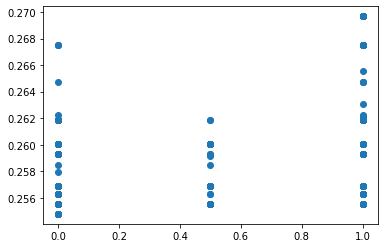

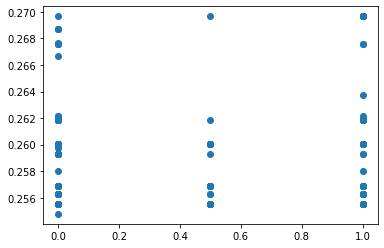

In [ ]:
plt.scatter(train['class'],trainPred);
plt.show();
plt.scatter(test['class'],testPred);
plt.show();

No handles with labels found to put in legend.


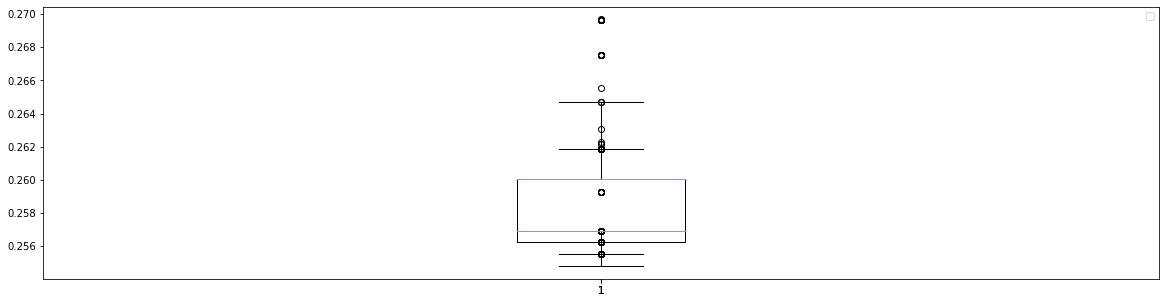

No handles with labels found to put in legend.


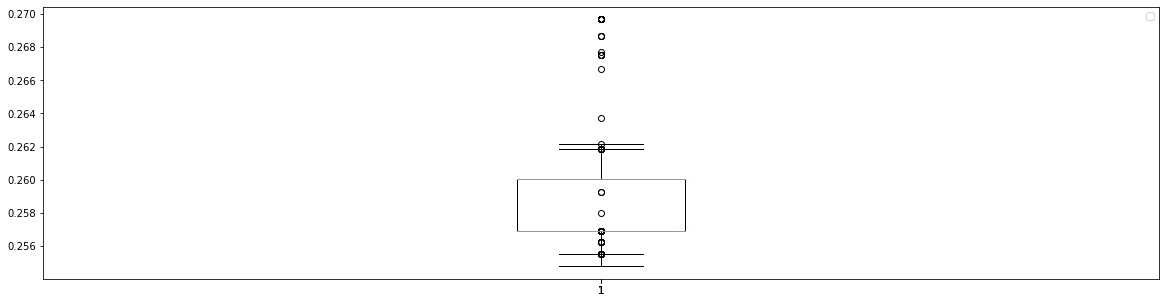

In [ ]:
plt.figure(figsize=(20,5))
for c in [0,0.5,1]:
    plt.boxplot(trainPred[train['class'] == c]);
plt.legend();
plt.show();
plt.figure(figsize=(20,5))
for c in [0,0.5,1]:
    plt.boxplot(testPred[test['class'] == c]);
plt.legend();
plt.show();

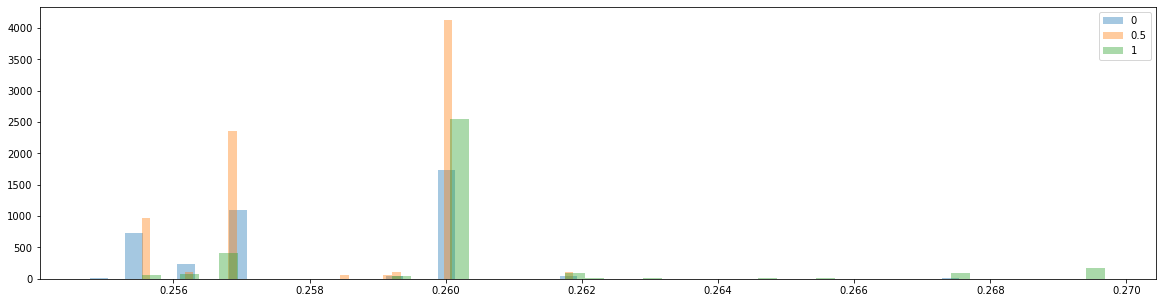

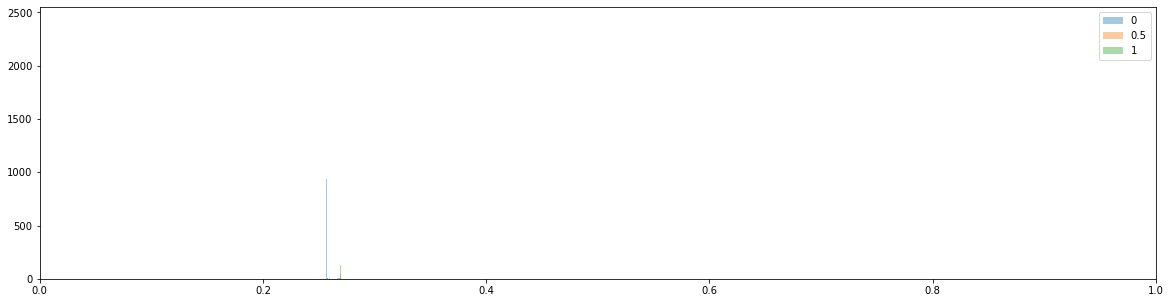

In [ ]:
plt.figure(figsize=(20,5))
for c in [0,0.5,1]:
    plt.hist(trainPred[train['class'] == c], label=c, alpha=0.4, density=True, bins=50);
plt.legend();
plt.show();

plt.figure(figsize=(20,5))
for c in [0,0.5,1]:
    plt.hist(testPred[test['class'] == c], label=c, alpha=0.4, density=True, bins=50);
plt.legend();
plt.xlim(0,1);
plt.show();

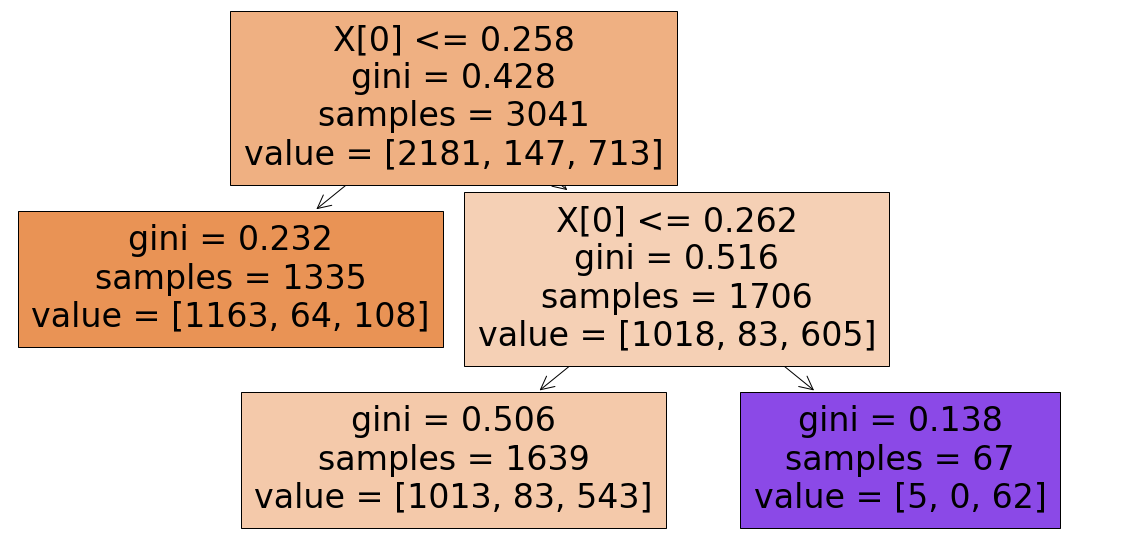

In [ ]:
plt.figure(figsize=(20,10)) 
plot_tree(classifier, filled=True) 
plt.show()

In [ ]:
predicted = resultArray(classifier, test,testPred.reshape(-1,1))

In [ ]:
predicted

{'CIC0009': {'turns': [{'turn-index': 0,
    'labels': [{'breakdown': 'O',
      'prob-O': 0.8711610486891386,
      'prob-T': 0.04794007490636704,
      'prob-X': 0.08089887640449438}]},
   {'turn-index': 2,
    'labels': [{'breakdown': 'O',
      'prob-O': 0.8711610486891386,
      'prob-T': 0.04794007490636704,
      'prob-X': 0.08089887640449438}]},
   {'turn-index': 4,
    'labels': [{'breakdown': 'O',
      'prob-O': 0.6180597925564368,
      'prob-T': 0.05064063453325198,
      'prob-X': 0.33129957291031115}]},
   {'turn-index': 6,
    'labels': [{'breakdown': 'O',
      'prob-O': 0.6180597925564368,
      'prob-T': 0.05064063453325198,
      'prob-X': 0.33129957291031115}]},
   {'turn-index': 8,
    'labels': [{'breakdown': 'O',
      'prob-O': 0.6180597925564368,
      'prob-T': 0.05064063453325198,
      'prob-X': 0.33129957291031115}]},
   {'turn-index': 10,
    'labels': [{'breakdown': 'O',
      'prob-O': 0.6180597925564368,
      'prob-T': 0.05064063453325198,
      'prob

O,O,2,0
O,O,4,2
O,O,6,4
X,O,8,6
X,X,10,8
X,O,12,10
O,O,14,12
O,O,16,14
X,O,18,16
O,X,20,18
O,O,1,1
X,X,3,3
O,O,5,5
T,O,7,7
O,X,9,9
O,O,11,11
X,O,13,13
O,O,15,15
O,O,17,17
O,O,19,19
O,O,2,0
O,O,4,2
T,O,6,4
O,O,8,6
X,O,10,8
O,O,12,10
X,O,14,12
T,O,16,14
X,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,X,10,8
X,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,1,1
X,X,3,3
O,O,5,5
X,O,7,7
X,X,9,9
O,O,11,11
X,X,13,13
X,X,15,15
O,X,17,17
O,O,19,19
O,O,1,1
O,O,3,3
X,X,5,5
O,O,7,7
O,O,9,9
O,O,11,11
O,O,13,13
O,X,15,15
O,O,17,17
X,O,19,19
O,O,2,0
O,O,4,2
O,O,6,4
X,O,8,6
O,O,10,8
O,O,12,10
X,O,14,12
X,O,16,14
X,O,18,16
X,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,X,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
T,O,20,18
T,O,2,0
O,O,4,2
O,O,6,4
X,O,8,6
O,O,10,8
X,X,12,10
O,O,14,12
X,O,16,14
X,O,18,16
O,O,20,18
O,O,2,0
O,X,4,2
X,O,6,4
O,X,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,X,16,14
X,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
X,O,8,6
O,O,10,8
X,O,12,10
X,O,14,12
O,O,16,14
O,O,18,16
X,O,20,18
O,

O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
T,O,4,2
O,O,6,4
T,O,8,6
O,O,10,8
X,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
X,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
T,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
T,O,10,8
O,O,12,10
T,O,14,12
O,X,16,14
O,O,18,16
O,O,20,18
O,O,2,0
T,O,4,2
O,O,6,4
X,O,8,6
T,O,10,8
O,O,12,10
O,X,14,12
O,O,16,14
O,O,18,16
T,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
T,O,12,10
O,O,14,12
O,O,16,14
T,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
T,O,10,8
X,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0

{'fileNumber': 123,
 'systemUtterance': 1230,
 'ansO': 850,
 'ansT': 74,
 'ansX': 306,
 'accuracy': 0.6560975609756098,
 'precisionX': 0.38222222222222224,
 'predX_ansX': 86,
 'total_predX': 225,
 'total_ansX': 306,
 'recallX': 0.28104575163398693,
 'f1X': 0.3239171374764595,
 'precisionTX': 0.8888888888888888,
 'recallTX': 0.19665683382497542,
 'f1TX': 0.322061191626409,
 'totalTXAnsX': 200,
 'totalPredX+PredT': 225,
 'totalAnsX': 1017,
 'js-O-T-X': 0.2876077926332945,
 'js-O-T+X': 0.25132921719754103,
 'js-O+T-X': 0.16431924830517416,
 'mse-O-T-X': 0.1679052034665323,
 'mse-O-T+X': 0.2814246964371014,
 'mse-O+T-X': 0.14930165483568208}

In [ ]:
evaluationAsDict(eval_data_path,predicted,0.5)

######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O Label Num : 		850
T Label Num : 		74
X Label Num : 		306

######### Results #########
Accuracy : 		0.692683 (852/1230)

Precision (X) : 	0.500000 (13/26)
Recall    (X) : 	0.042484 (13/306)
F-measure (X) : 	0.078313

Precision (T+X) : 	0.884615 (23/26)
Recall    (T+X) : 	0.022616 (23/1017)
F-measure (T+X) : 	0.044104

JS divergence (O,T,X) : 	0.193345
JS divergence (O,T+X) : 	0.161276
JS divergence (O+T,X) : 	0.057142

Mean squared error (O,T,X) : 	0.111927
Mean squared error (O,T+X) : 	0.197952
Mean squared error (O+T,X) : 	0.060853
###########################


{'fileNumber': 123,
 'systemUtterance': 1230,
 'ansO': 850,
 'ansT': 74,
 'ansX': 306,
 'accuracy': 0.6926829268292682,
 'precisionX': 0.5,
 'predX_ansX': 13,
 'total_predX': 26,
 'total_ansX': 306,
 'recallX': 0.042483660130718956,
 'f1X': 0.0783132530120482,
 'precisionTX': 0.8846153846153846,
 'recallTX': 0.02261553588987217,
 'f1TX': 0.04410354745925216,
 'totalTXAnsX': 23,
 'totalPredX+PredT': 26,
 'totalAnsX': 1017,
 'js-O-T-X': 0.19334463300925875,
 'js-O-T+X': 0.1612763840726417,
 'js-O+T-X': 0.057141985890017066,
 'mse-O-T-X': 0.11192679160734208,
 'mse-O-T+X': 0.19795183137170158,
 'mse-O+T-X': 0.06085345547707802}

In [ ]:
pd.DataFrame(classification_report(test['class'].astype(str).values.reshape(-1,1), testPred2.reshape(-1,1),output_dict=True))

,0.0,0.5,1.0,accuracy,macro avg,weighted avg
precision,0.486804,0.294444,0.549165,0.458065,0.443471,0.465910
recall,0.389671,0.352159,0.576998,0.458065,0.439610,0.458065
f1-score,0.432855,0.320726,0.562738,0.458065,0.438773,0.459370
support,426.000000,301.000000,513.000000,0.458065,1240.000000,1240.000000


In [ ]:
classification_report(test['class'].astype(str).values.reshape(-1,1), testPred2.reshape(-1,1),output_dict=True)

{'0.0': {'precision': 0.4868035190615836,
  'recall': 0.38967136150234744,
  'f1-score': 0.43285528031290743,
  'support': 426},
 '0.5': {'precision': 0.29444444444444445,
  'recall': 0.3521594684385382,
  'f1-score': 0.3207261724659607,
  'support': 301},
 '1.0': {'precision': 0.549165120593692,
  'recall': 0.5769980506822612,
  'f1-score': 0.5627376425855514,
  'support': 513},
 'accuracy': 0.45806451612903226,
 'macro avg': {'precision': 0.44347102803324007,
  'recall': 0.43960962687438226,
  'f1-score': 0.4387730317881398,
  'support': 1240},
 'weighted avg': {'precision': 0.46590950303433576,
  'recall': 0.45806451612903226,
  'f1-score': 0.4593704338483392,
  'support': 1240}}

In [ ]:
pipeline.fit(train, train['class'])

[21:32:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('user-utterance-vector',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ItemSelector(key='user-utterance-tail')),
                                                                 ('W2VecSelector',
                                                                  W2VecSelector(w2v=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x0000021E829E1278>)),
                                                                 ('pca',
                                                                  PCA(copy=True,
                                                                      iterated_power='auto',
                                                                      n_compon...


In [ ]:
grid = GridSearchCV(pipeline, tuned_parameters, scoring = 'neg_mean_absolute_error', n_jobs= 2)
grid.fit(train, train['class'])

MemoryError: 

In [ ]:
def convertToClass(array, min, med, max):
    result = []
    for a in array:
        current_class = None
        if a > min and a < med:
            current_class = 'O'
        elif a >= med and a < max:
            current_class = 'T'
        else:
            current_class = 'X'
        result.append(current_class)
    return result
            

In [ ]:
min = -1
med = 0.49
max = 0.51
print(classification_report(convertToClass(np.asarray(test['class']),-1,0.2,0.7), convertToClass(y,min,med,max)))

              precision    recall  f1-score   support

           O       0.76      0.17      0.27       426
           T       0.25      0.93      0.40       301
           X       0.60      0.05      0.09       513

    accuracy                           0.30      1240
   macro avg       0.54      0.38      0.26      1240
weighted avg       0.57      0.30      0.23      1240



In [ ]:
xpto = pipeline.predict_proba(test.iloc[[1]])
#xpto[0][2]
#pipeline.predict(test.iloc[[1]])
test.iloc[1].file_name

AttributeError: 'StackingRegressor' object has no attribute 'predict_proba'

In [ ]:
y = pipeline.predict(test)

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [ ]:
y

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [ ]:
print(np.asarray(test['class']))

[0.  0.5 1.  ... 0.  0.5 0.5]


In [ ]:
from sklearn.metrics import r2_score
r2_score(test['class'],y)

0.02874226119785972

(array([358., 336., 222., 160.,  39.,  18.,  13.,   1.,   1.,   2.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

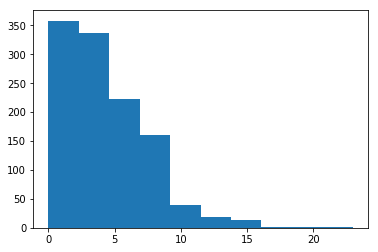

In [ ]:
plt.hist( (  CountVectorizer().fit_transform(train['user-utterance']) >0 ).sum(axis=1))

(array([669., 238., 143.,  47.,  25.,  13.,   5.,   5.,   3.,   2.]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <a list of 10 Patch objects>)

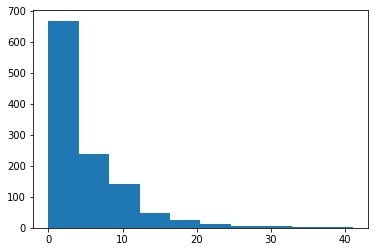

In [ ]:
plt.hist( (  CountVectorizer(binary=True).fit_transform(train['system-utterance']) >0 ).sum(axis=1))

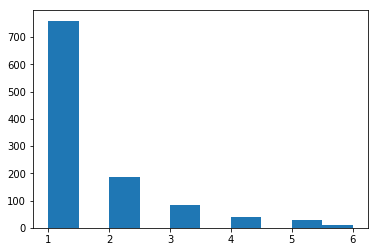

In [ ]:
plt.hist(np.array(CountVectorizer(binary=True,max_df=6).fit_transform(train['user-utterance']).sum(axis=0))[0]);

In [ ]:
dict_test = {}
for index,row in test.iterrows():
    if not isinstance(row['classCHAR'],float):
        dict_test[row['dialogue-id']+'-'+str(row['system-index'])] = row['classCHAR']
    else:
        dict_test[row['dialogue-id']+'-'+str(row['system-index'])] = 'O'
#dict_test
#saveDictionaryAsJson('C:/Users/leona/Dropbox/python/teste_estatistico/','ENG-test.json',dict_test)

In [ ]:
json.dumps(dict_test)

'{"Bot001_023-0": "O", "Bot001_023-2": "O", "Bot001_023-4": "O", "Bot001_023-6": "X", "Bot001_023-8": "O", "Bot001_023-10": "O", "Bot001_023-12": "O", "Bot001_023-14": "O", "Bot001_023-16": "O", "Bot001_023-18": "O", "Bot001_023-20": "O", "Bot003_080-0": "O", "Bot003_080-2": "O", "Bot003_080-4": "O", "Bot003_080-6": "O", "Bot003_080-8": "O", "Bot003_080-10": "O", "Bot003_080-12": "O", "Bot003_080-14": "X", "Bot003_080-16": "O", "Bot003_080-18": "X", "Bot003_080-20": "X", "Bot001_066-0": "O", "Bot001_066-2": "O", "Bot001_066-4": "O", "Bot001_066-6": "O", "Bot001_066-8": "O", "Bot001_066-10": "O", "Bot001_066-12": "O", "Bot001_066-14": "T", "Bot001_066-16": "T", "Bot001_066-18": "O", "Bot001_066-20": "O", "iris_DBDC4_098-0": "O", "iris_DBDC4_098-2": "O", "iris_DBDC4_098-4": "O", "iris_DBDC4_098-6": "O", "iris_DBDC4_098-8": "T", "iris_DBDC4_098-10": "O", "iris_DBDC4_098-12": "X", "iris_DBDC4_098-14": "O", "iris_DBDC4_098-16": "O", "iris_DBDC4_098-18": "O", "iris_DBDC4_098-20": "X", "Bot00